# Setup environment

In [3]:
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

from bargaining_utility_functions import synthetic_data, import_bayaka, import_agta

# BaYaka

In [4]:
bayaka_data = import_bayaka()

bayaka_leisure_ratio = bayaka_data.leisureratio.values
bayaka_average_age = (bayaka_data.agem.values + bayaka_data.agefem.values) / 2
bayaka_age_difference = bayaka_data.agem.values - bayaka_data.agefem.values
bayaka_dependants = bayaka_data.dependants.values

# find stick differences

stick_difference = bayaka_data.male_social.values - bayaka_data.female_social.values
bayaka_data['stick_difference'] = stick_difference
bayaka_data['difference_in_z_score'] = bayaka_data.male_z_social - bayaka_data.female_z_social

bayaka_data

ID   agem  agefem  camp  male_social  female_social   
0   CML00201M060  26.25   29.37     0            1              4  \
1   CML00403M097  21.48   19.41     0            2              0   
2   CML00405M100  62.86   50.63     0            1              0   
3   CML00906M239  45.58   35.35     0            8              4   
4   CML00110M036  66.28   47.25     0            4              1   
5   CML00114M044  26.67   24.35     0            9              5   
6   CML00117M056  38.05   35.73     0            8              3   
7   CMA01702M653  60.11   50.84     1            8              3   
8   CML01202M213  42.22   40.00     1            1              2   
9   CMA01704M661  28.66   20.00     1            7              0   
10  CMA01705M663  40.00   27.69     1            2              2   
11  CMA01706M669  41.28   40.34     1            6              3   
12  CMA01708M651  26.87   23.30     1            2              3   
13  CML01202M213  42.22   40.00     1            1              0   
14  CML01203M216  23.60   21.72     1            2              0   
15  CMI01401M276  42.46   32.10     2            0              1   
16  CMI01402M283  28.30   19.08     2            0              2   
17  CMI01402M286  37.90   32.97     2            3              2   
18  CMI01403M294  27.65   25.15     2            4              2   
19  CMI01404M298  33.85   31.27     2            3              4   
20  CMI01407M315  49.58   40.87     2            4              2   
21  CMI01407M316  39.27   23.29     2            3              5   
22  CMI01408M327  36.50   35.63     2            5              2   

    leisurem_counts  leisuref_counts  budget  leisureratio  dependants   
0                30               21      51      0.534682           1  \
1                 4                3       7      0.571429           1   
2                15               10      25      0.600000           3   
3                26               12      38      0.635403           5   
4                 8                7      15      0.533333           5   
5                42               28      70      0.546798           1   
6                29               14      43      0.610526           4   
7                13               18      31      0.419355           1   
8                27               44      71      0.398722           4   
9                24               26      50      0.480000           1   
10               35               38      73      0.520548           1   
11               23               20      43      0.294479           1   
12               22               29      51      0.431373           2   
13               44               27      71      0.398722           4   
14               20                4      24      0.478261           2   
15               77                7      84      0.274895           1   
16               41               58      99      0.414141           2   
17               59               48     107      0.551402           6   
18               11               41      52      0.271605           1   
19               52               57     109      0.477064           3   
20               48               22      70      0.672280           6   
21               53               48     101      0.524752           3   
22               61               48     109      1.000000           6   

    male_z_social  female_z_social  stick_difference  difference_in_z_score  
0       -0.880409         0.146735                -3              -1.027144  
1       -0.538028        -1.222790                 2               0.684762  
2       -0.880409        -1.222790                 1               0.342381  
3        1.516260         0.146735                 4               1.369525  
4        0.146735        -0.880409                 3               1.027144  
5        1.858641         0.489116                 4               1.369525  
6        1.516260        -0.195646

In [5]:
bayaka_data.difference_in_z_score.values.mean(), bayaka_data.difference_in_z_score.values.std() 

(0.5934009062808842, 1.1462765573069242)

In [6]:
np.mean(bayaka_data.leisurem_counts.values / bayaka_data.budget.values), np.std(bayaka_data.leisurem_counts.values / bayaka_data.budget.values)

(0.5552580542090229, 0.14553839262053198)

In [7]:
x = bayaka_data.male_z_social.values
y = bayaka_data.female_z_social.values

np.corrcoef(x,y)

array([[1.        , 0.31360764],
       [0.31360764, 1.        ]])

In [8]:
x = bayaka_data.male_z_social.values
y = bayaka_data.female_z_social.values

stats.pearsonr(x,y)

PearsonRResult(statistic=0.3136076378502935, pvalue=0.14506302480010363)

## Prior modeling

In [9]:
# differences in z scores version

k = bayaka_data.leisurem_counts.values
n = bayaka_data.budget.values

x1 = bayaka_data.difference_in_z_score.values
x2 = bayaka_average_age
x3 = bayaka_age_difference
x4 = bayaka_dependants
camp = bayaka_data.camp.values

with pm.Model() as m1_bayaka:
    
    # hyper prior
    hb1mu = pm.Normal('group-level social capital',0,0.5)
    hb1std = pm.Exponential('group-level variation',1)
    
    # intercept
    a = pm.Normal('intercept',0,2)
    
    # slope
    bz = pm.Normal('bz',hb1mu,1,shape=3)
    b1 = pm.Deterministic('camp-level social capital',hb1std*bz)
    b2 = pm.Normal('average age',0.01,0.02)
    b3 = pm.Normal('age difference',0.01,0.03)
    b4 = pm.Normal('dependants',0,0.2)
    
    # regression equation
    p = pm.invlogit(a + b1[camp]*x1 + b2*x2 + b3*x3 + b4*x4)
    p = pm.Deterministic('p',p)
    
    # outcome distribution
    y = pm.Binomial('y',p=p,n=n,observed=k)

### social capital effect prior prediction

We simulated the largest possible effect size we could using synthetic data to determine the upper bound on the logistic regression effect coefficient.

In [10]:
data = synthetic_data(300,3,-0.5,0.4,0.00)
k = data.leisurem_counts.values
n = data.budget.values
x = data.difference_in_z_score.values

with pm.Model() as max_effective_size:
    
    # priors
    
    # intercept
    a = pm.Normal('a',0,5)
    
    # slope
    b = pm.Normal('b',0,5)
    
    # regression equation
    p = pm.invlogit(a + b*x)
    p = pm.Deterministic('p',p)
    
    # outcome distribution
    y = pm.Binomial('y',p=p,n=n,observed=k)
    t_max_effective_size = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
c:\Users\dsaun\Anaconda3\envs\pymc_env\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


1.2871250398585445


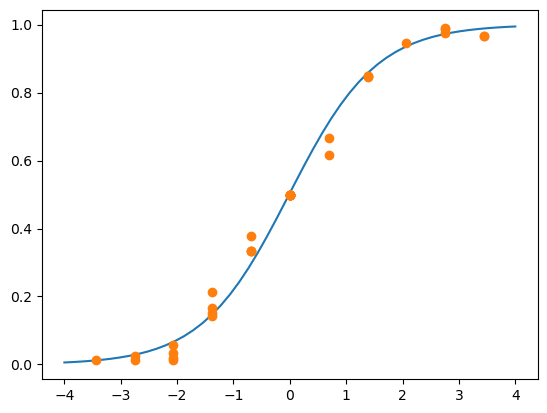

In [11]:
#x = data.male_social_capital.values - data.female_social_capital.values
x = data.difference_in_z_score.values
y = data.leisurem_counts.values / data.budget.values

a = t_max_effective_size.posterior['a'].mean(('chain','draw')).values
b = t_max_effective_size.posterior['b'].mean(('chain','draw')).values
xs = np.linspace(-4,4,50)
ys = np.exp(a + b*xs) / (1 + np.exp(a + b*xs))

plt.plot(xs,ys)
plt.plot(x,y,'o')
print(b)

### Camp effect prior prediction

Visualize what the social capital effect might look like across all three camps. This code samples from the multi-level prior structure.

Sampling: [age difference, average age, bz, dependants, group-level social capital, group-level variation, intercept, y]


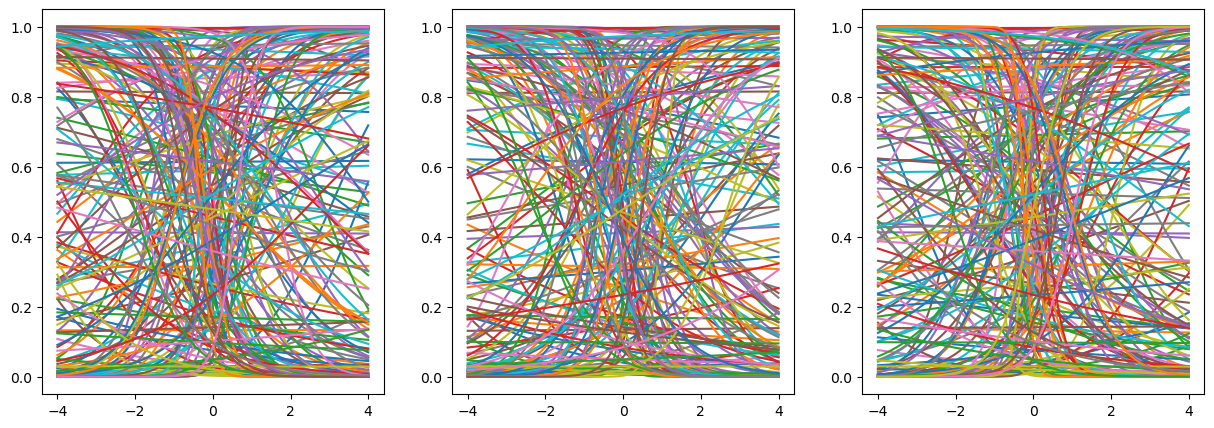

In [12]:
num_samples = 200

with m1_bayaka:
    pp1 = pm.sample_prior_predictive(num_samples)

x = np.linspace(-4,4,100)

f,ax = plt.subplots(1,3,figsize=(15,5))

for i in range(num_samples):

    a = pp1.prior['intercept'][0][i].values
    b_0 = pp1.prior['camp-level social capital'][0][i,0].values
    b_1 = pp1.prior['camp-level social capital'][0][i,1].values
    b_2 = pp1.prior['camp-level social capital'][0][i,2].values
    
    #print(b_0)
    
    y_0 = np.exp(a + b_0 * x) / (1 + np.exp(a + b_0 * x))
    y_1 = np.exp(a + b_1 * x) / (1 + np.exp(a + b_1 * x))
    y_2 = np.exp(a + b_2 * x) / (1 + np.exp(a + b_2 * x))
    
    ax[0].plot(x,y_0)
    ax[1].plot(x,y_1)
    ax[2].plot(x,y_2)

### Age effects prior prediction

Visualize what the age effects look like individually. Differences first.

(0.0, 1.0)

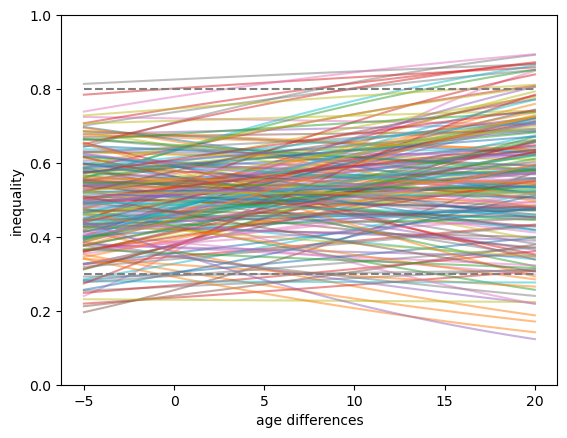

In [13]:
x = np.linspace(-5,20,100)

for i in range(200):

    a = stats.norm(0,0.5).rvs()
    b = stats.norm(0.01,0.03).rvs()

    y = b * x + a
    y = np.exp(y) / (1 + np.exp(y))

    plt.plot(x,y,alpha=0.5)
    
#plt.plot(x,[0.5]*100,'--',color='grey')
plt.plot(x,[0.8]*100,'--',color='grey')
plt.plot(x,[0.3]*100,'--',color='grey')
plt.ylabel('inequality')
plt.xlabel('age differences')
plt.ylim([0,1])

Then average age.

(0.0, 1.0)

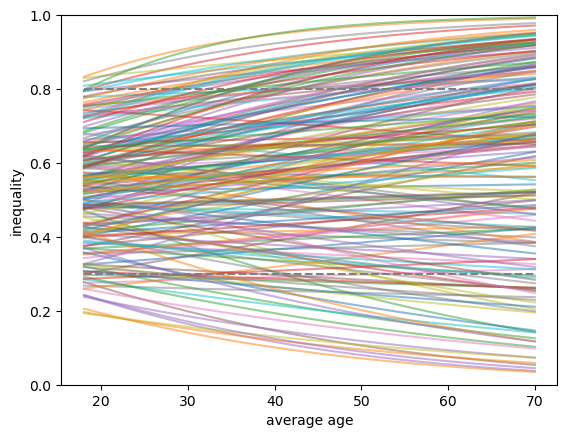

In [14]:
# coefficient scale when x is [18-100]

x = np.linspace(18,70,100)

for i in range(200):

    a = stats.norm(0,0.5).rvs()
    b = stats.norm(0.01,0.02).rvs()

    y = b * x + a
    y = np.exp(y) / (1 + np.exp(y))

    plt.plot(x,y,alpha=0.5)
    
#plt.plot(x,[0.5]*100,'--',color='grey')
plt.plot(x,[0.8]*100,'--',color='grey')
plt.plot(x,[0.3]*100,'--',color='grey')
plt.ylabel('inequality')
plt.xlabel('average age')
plt.ylim([0,1])

### Dependents

(0.0, 1.0)

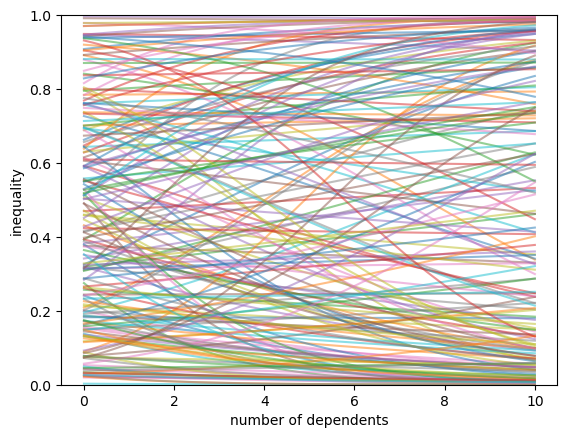

In [15]:
x = np.linspace(0,10,100)

for i in range(200):

    a = stats.norm(0,2).rvs()
    b = stats.norm(0,0.2).rvs()

    y = b * x + a
    y = np.exp(y) / (1 + np.exp(y))

    plt.plot(x,y,alpha=0.5)
    
plt.ylabel('inequality')
plt.xlabel('number of dependents')
plt.ylim([0,1])

### Composite prediction

Visualize the effect of all our priors interacting simultaneously.

Sampling: [age difference, average age, bz, dependants, group-level social capital, group-level variation, intercept, y]


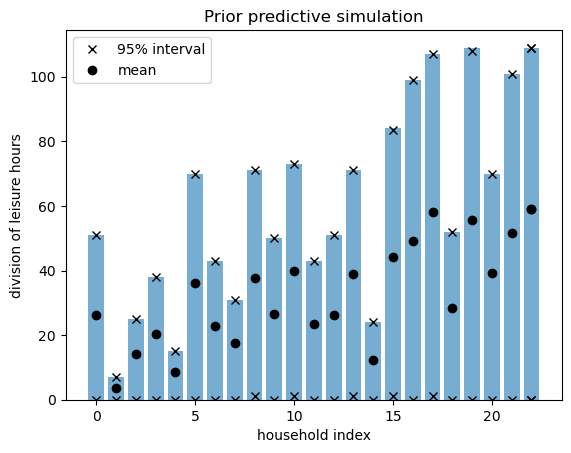

In [19]:
k = bayaka_data.leisurem_counts.values
n = bayaka_data.budget.values

num_samples = 500

with m1_bayaka:
    pp1 = pm.sample_prior_predictive(num_samples)
    
x = np.arange(23)

plt.bar(x,n,alpha=0.6)

for i in range(23):
    top = np.percentile(pp1.prior_predictive['y'][0][:,i],97.5)
    bottom = np.percentile(pp1.prior_predictive['y'][0][:,i],2.5)
    mean = pp1.prior_predictive['y'][0][:,i].mean().values
    plt.plot(i,top,'x',color="black")
    plt.plot(i,bottom,'x',color="black")
    plt.plot(i,mean,'o',color="black")
    
plt.plot(i,top,'x',color="black")
plt.plot(i,bottom,'x',color="black",label="95% interval")
plt.plot(i,mean,'o',color="black",label="mean")
    
plt.title('Prior predictive simulation')
plt.xlabel('household index')
plt.ylabel('division of leisure hours')
plt.legend()

## Sampling

In [20]:
rs = RandomState(MT19937(SeedSequence(123456789)))

with m1_bayaka:
    t1 = pm.sample(tune=2000,draws=2000,target_accept=0.9,chains=4,random_seed=rs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group-level social capital, group-level variation, intercept, bz, average age, age difference, dependants]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 72 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


In [21]:
t1.to_json('trace_bayaka')

'trace_bayaka'

In [22]:
t1 = az.from_json('trace_bayaka')

c:\Users\dsaun\Anaconda3\envs\pymc_env\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


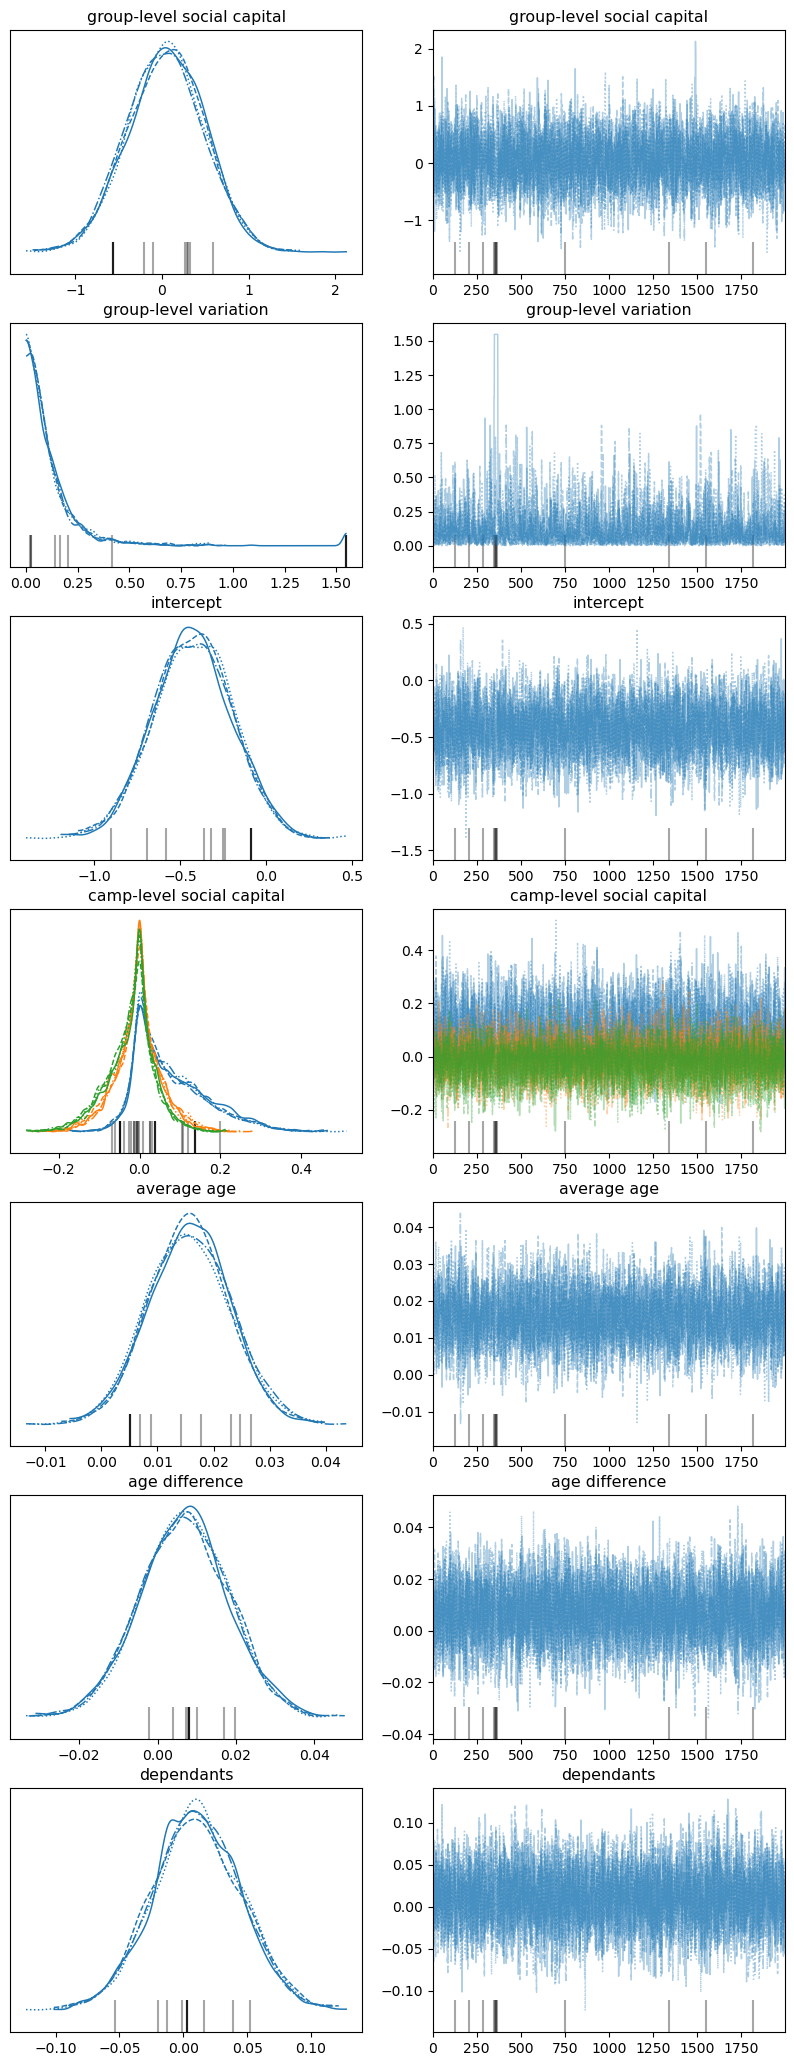

In [23]:
var_names=['group-level social capital','group-level variation',"intercept",'camp-level social capital','average age','age difference','dependants']

az.plot_trace(t1,var_names=var_names,figsize=(10,26));

In [24]:
var_names=['group-level social capital','group-level variation',"intercept",'camp-level social capital','average age','age difference','dependants']

az.summary(t1,var_names=var_names,hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean   
group-level social capital    0.047  0.446    -0.832      0.897      0.006  \
group-level variation         0.115  0.141     0.000      0.350      0.005   
intercept                    -0.426  0.229    -0.862      0.030      0.003   
camp-level social capital[0]  0.075  0.090    -0.054      0.281      0.002   
camp-level social capital[1] -0.005  0.058    -0.130      0.115      0.001   
camp-level social capital[2] -0.022  0.059    -0.154      0.090      0.001   
average age                   0.016  0.007     0.002      0.030      0.000   
age difference                0.007  0.011    -0.016      0.028      0.000   
dependants                    0.011  0.034    -0.055      0.080      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
group-level social capital      0.005    5372.0    5411.0    1.0  
group-level variation           0.005    1883.0    2283.0    1.0  
intercept                       0.002    4776.0    4799.0    1.0  
camp-level social capital[0]    0.001    3022.0    6454.0    1.0  
camp-level social capital[1]    0.001    6975.0    6747.0    1.0  
camp-level social capital[2]    0.001    5377.0    6621.0    1.0  
average age                     0.000    4516.0    4591.0    1.0  
age difference                  0.000    5714.0    5139.0    1.0  
dependants                      0.000    5651.0    5107.0    1.0

## Results

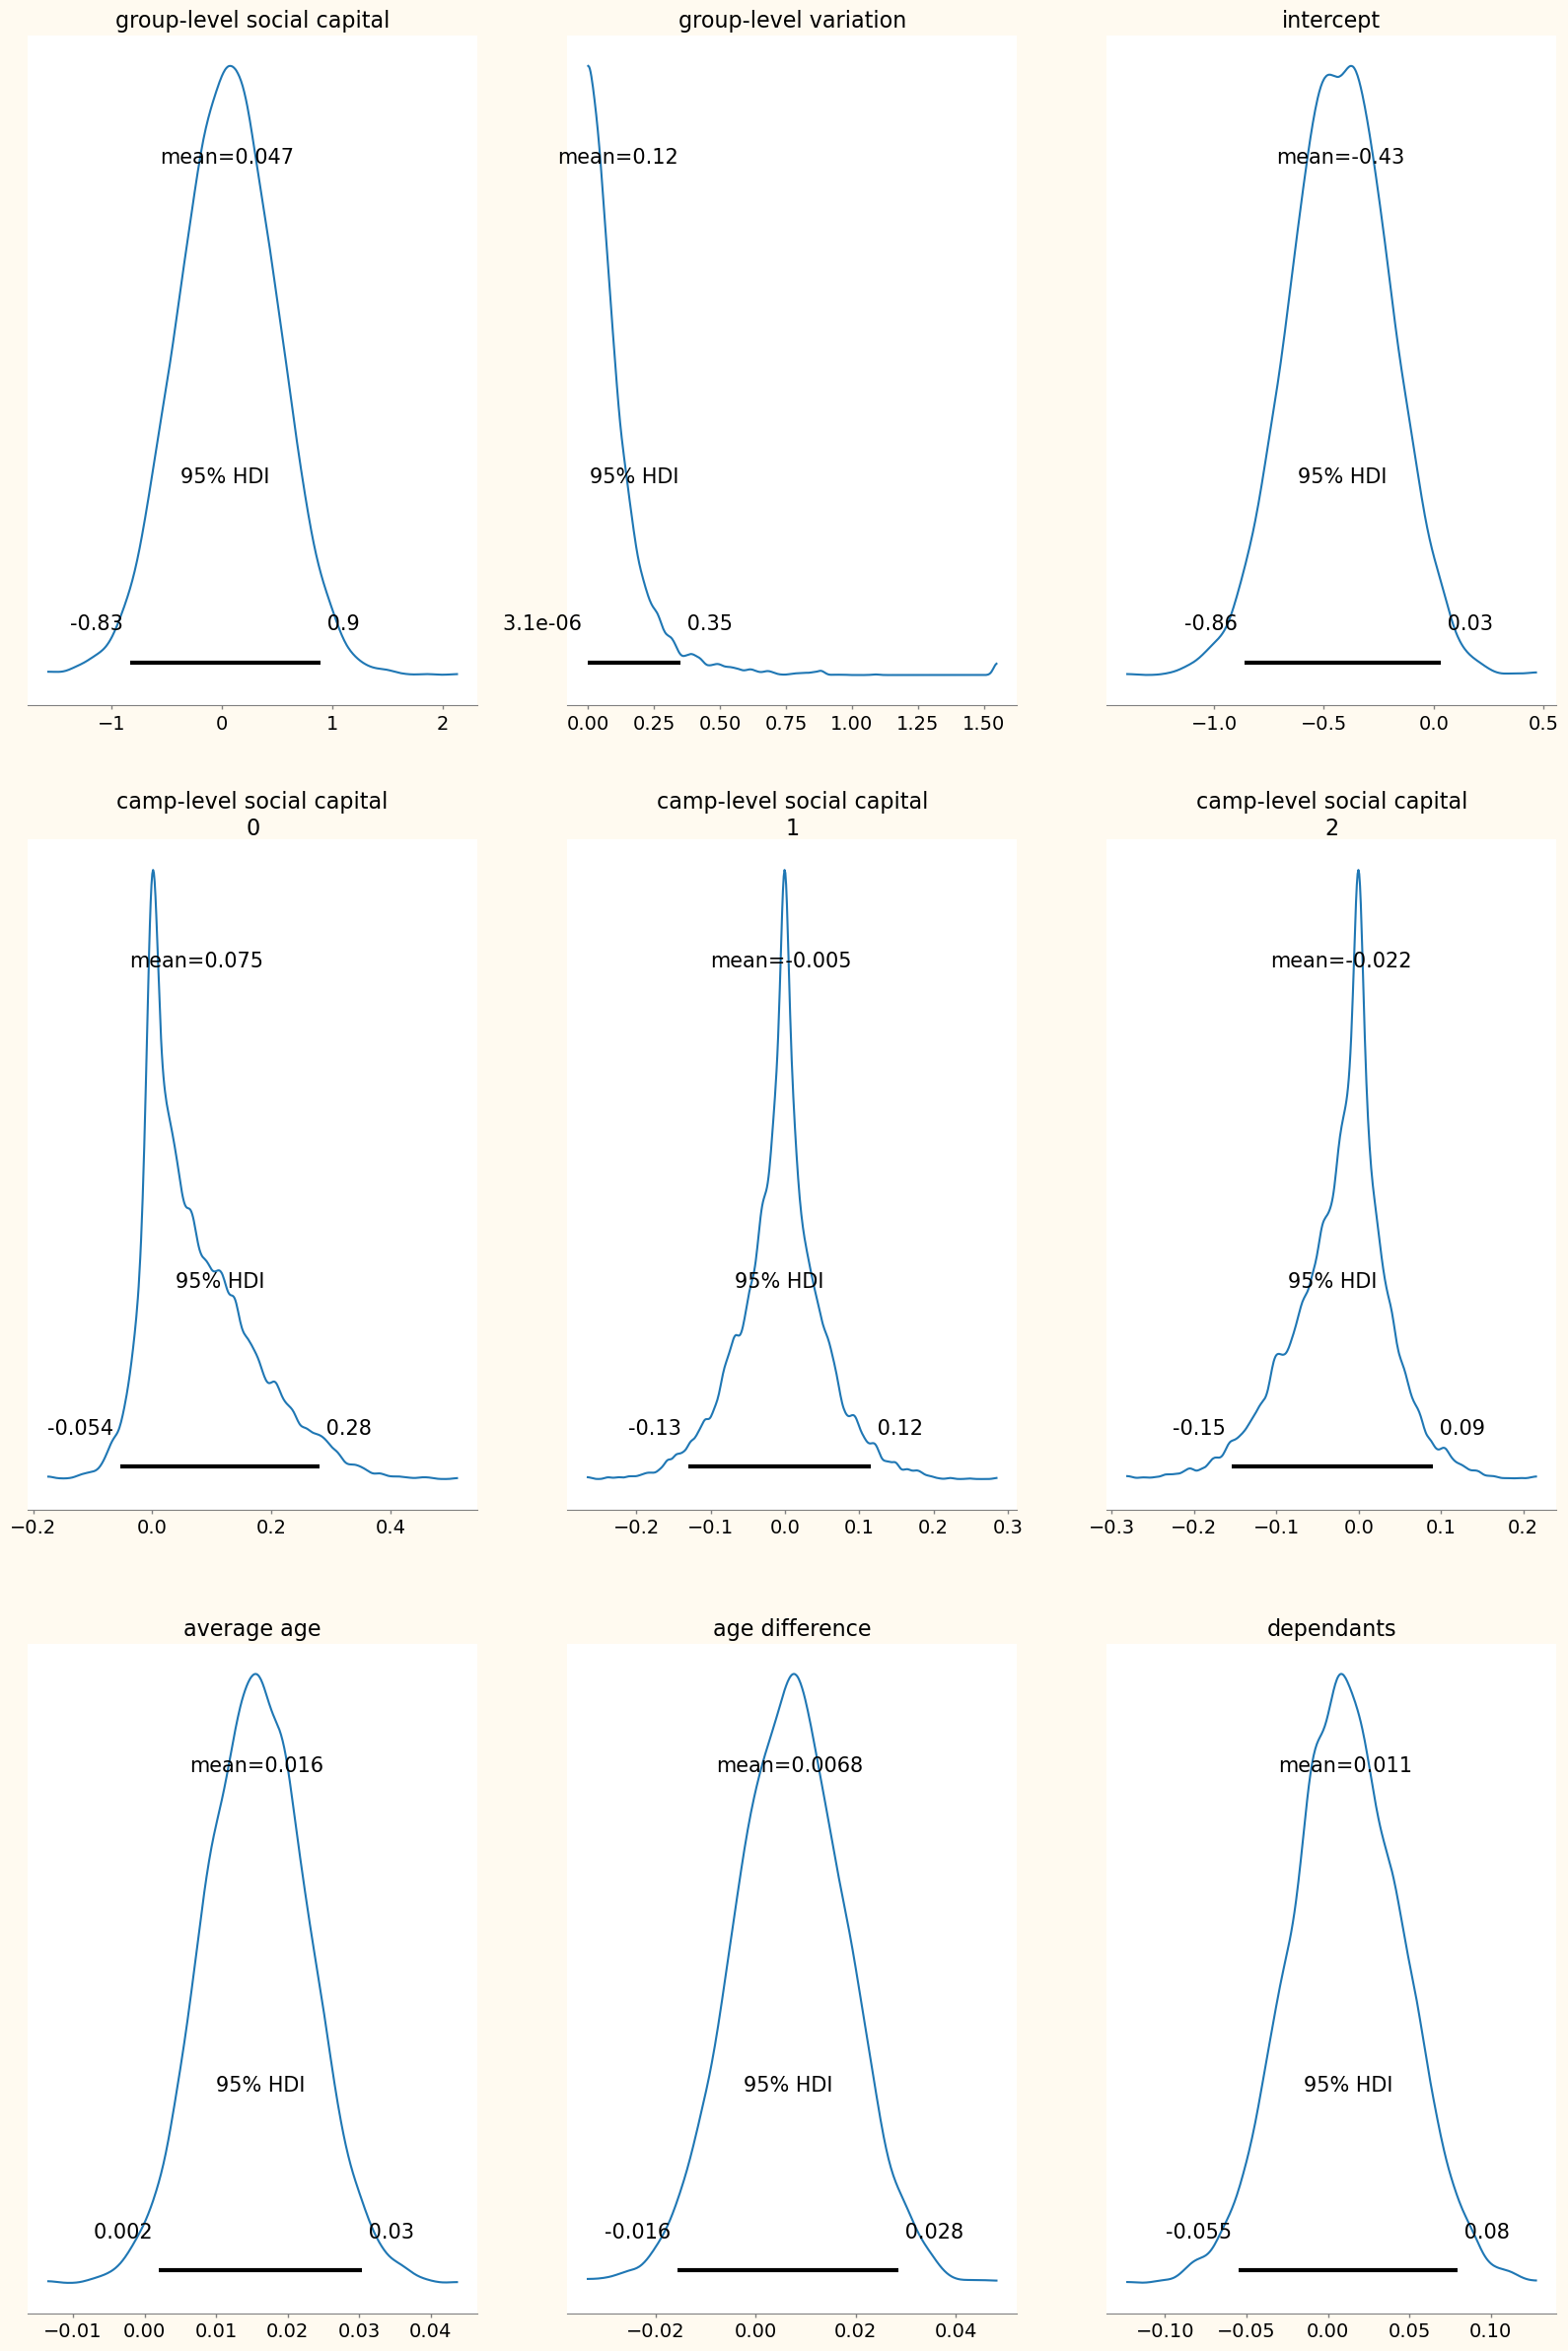

In [25]:
var_names=['group-level social capital','group-level variation',"intercept",'camp-level social capital','average age','age difference','dependants']

az.plot_posterior(t1,var_names=var_names,hdi_prob=0.95,figsize=(20,30),backend_kwargs={'facecolor':"floralwhite"});

## Posterior Checks

A range of visualizations to help us interpret the posterior distribution.

### Composite effect

Visualize what overall posterior for all parameters says about the outcome variable. One way to get a sense for how much the model learned about the data is to compare this plot to the composite predictions.

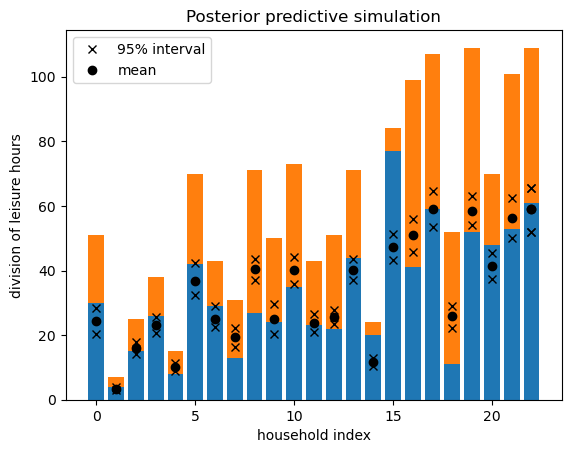

In [26]:
x = np.arange(len(bayaka_data))
n = bayaka_data.budget.values
k = bayaka_data.leisurem_counts.values

plt.bar(x,k)
plt.bar(x,n-k,bottom=k)

for i in range(len(bayaka_data)):
    top = n[i]* np.percentile(t1.posterior['p'][:,:,i],97.5)
    bottom = n[i]*np.percentile(t1.posterior['p'][:,:,i],2.5)
    mean = n[i]*t1.posterior['p'][:,:,i].mean().values
    plt.plot(i,top,'x',color="black")
    plt.plot(i,bottom,'x',color="black")
    plt.plot(i,mean,'o',color="black")
    
plt.plot(i,top,'x',color="black")
plt.plot(i,bottom,'x',color="black",label="95% interval")
plt.plot(i,mean,'o',color="black",label="mean")
    
plt.title('Posterior predictive simulation')
plt.xlabel('household index')
plt.ylabel('division of leisure hours')
plt.legend()

(0.0, 1.0)

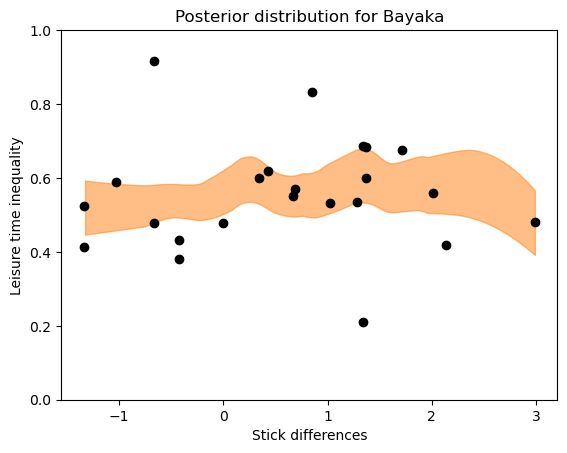

In [27]:
#x = bayaka_data.stick_difference.values
x = bayaka_data.difference_in_z_score.values
k = bayaka_data.leisurem_counts.values
n = bayaka_data.budget.values

az.plot_hdi(x,t1.posterior['p'],hdi_prob=0.95)
plt.plot(x,k/n,'o',color='black',label='observed')
plt.title('Posterior distribution for Bayaka')
plt.xlabel('Stick differences')
plt.ylabel('Leisure time inequality')
plt.ylim([0,1])

Sampling: [y]


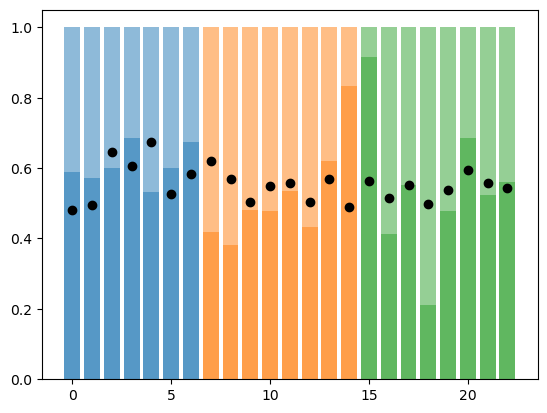

In [28]:
post_pred_bayaka = pm.sample_posterior_predictive(t1,model=m1_bayaka)

pred_samples = post_pred_bayaka.posterior_predictive['y'].values.reshape((8000,23))

x = np.arange(23)

camp_colors = ['tab:blue','tab:orange','tab:green']
ceiling = np.ones(23)

for i in range(23):
    top = np.percentile(pred_samples[:,i],97.5)
    bottom = np.percentile(pred_samples[:,i],2.5)
    mean = pred_samples[:,i].mean()
    plt.plot(i,(mean/n)[i],'o',color="black")
    plt.bar(i,(k/n)[i],color=camp_colors[camp[i]],alpha=0.5)
    plt.bar(i,ceiling[i],color=camp_colors[camp[i]],alpha=0.5)

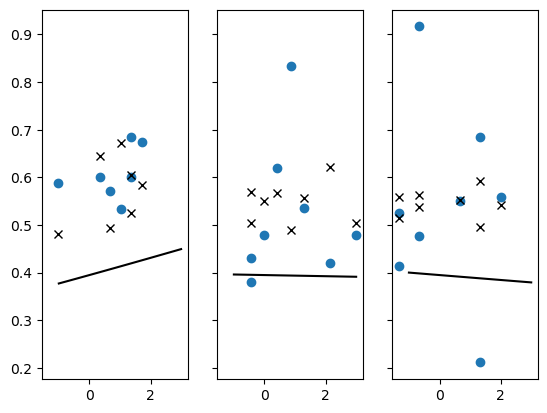

In [29]:
f, ax = plt.subplots(1,3,sharex=True,sharey=True)

pred_samples = post_pred_bayaka.posterior_predictive['y'].values.reshape((8000,23))
pred_k = pred_samples.mean(axis=0)

a = t1.posterior['intercept'].mean(('chain','draw')).values
b = t1.posterior['camp-level social capital'].mean(('chain','draw')).values

x = np.linspace(-1,3)

for i in range(3):
    
    y = np.exp(a + b[i]*x) / (1 + np.exp(a + b[i]*x))
    
    ax[i].plot(x,y,color="black")
    ax[i].plot(x1[camp == i],k[camp == i]/n[camp == i],'o')
    ax[i].plot(x1[camp == i],pred_k[camp == i]/n[camp == i],'x',color="black")

### Relational wealth group-level effect

Visualize just the aggregate group-level relational wealth effect.

(-2.5, 3.1)

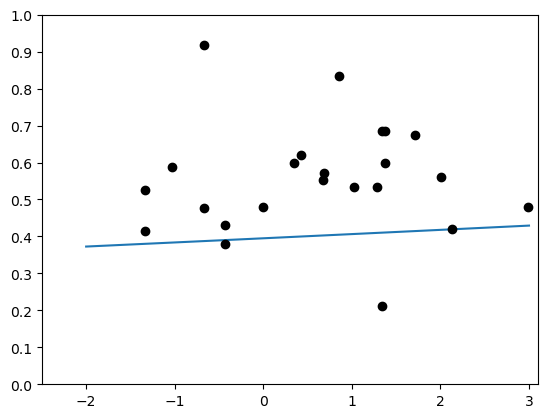

In [30]:
x = np.linspace(-2,3,100)

k = bayaka_data.leisurem_counts.values
n = bayaka_data.budget.values

a = t1.posterior['intercept'].mean(('chain','draw')).values
b = t1.posterior['group-level social capital'].mean(('chain','draw')).values

y = np.exp(a + b*x) / (1 + np.exp(a + b*x))

plt.plot(x,y)
plt.plot(bayaka_data.difference_in_z_score.values,k/n,'o',color='black')
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks([-2,-1,0,1,2,3])
plt.ylim([0,1])
plt.xlim([-2.5,3.1])

The next plot depicts uncertainty. I sampled the bottom of the posterior distribution on the group-level effect, the top and the mean and plotted all of them.

C:\Users\dsaun\AppData\Local\Temp\ipykernel_9268\2408413464.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(ys)


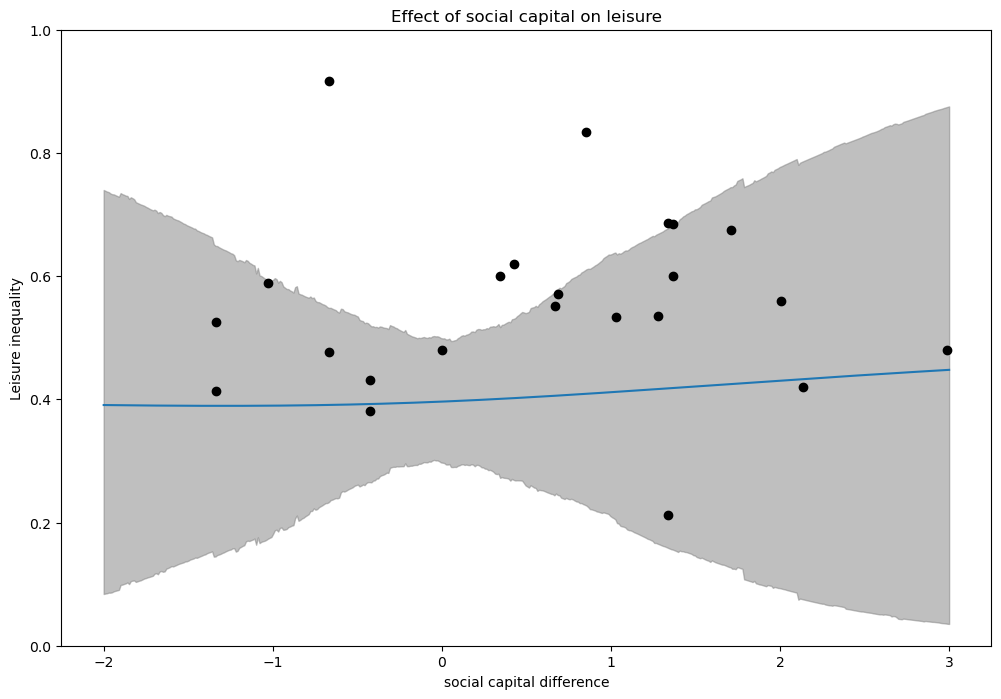

In [31]:
x = np.linspace(-2,3,500)

k = bayaka_data.leisurem_counts.values
n = bayaka_data.budget.values

intercepts = t1.posterior['intercept'].values.flatten()
slopes = t1.posterior['group-level social capital'].values.flatten()

ys = []

for i in range(8000):

    a = intercepts[i]
    b = slopes[i]
    y = np.exp(a + b*x) / (1 + np.exp(a + b*x))
    ys.append(y)
    
ys = np.array(ys)
hdis = az.hdi(ys)
y = ys.mean(axis=0) 
y1 = hdis[:,0]
y2 = hdis[:,1]

plt.figure(figsize=(12,8))

plt.plot(x,y)
plt.fill_between(x,y1,y2,color="grey",alpha=0.5)
plt.plot(bayaka_data.difference_in_z_score.values,k/n,'o',color='black',label='observed')
plt.ylim([0,1])
plt.xlabel("social capital difference")
plt.ylabel("Leisure inequality")
plt.title("Effect of social capital on leisure");

### Age effects

(0.0, 1.0)

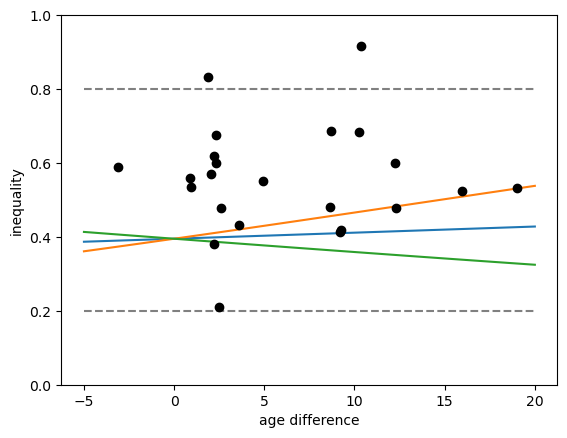

In [32]:
# coefficient scale when x = [-5,20]

x = np.linspace(-5,20,100)
a = t1.posterior['intercept'].mean(('chain','draw')).values
b = t1.posterior['age difference'].mean(('chain','draw')).values
b1 = np.percentile(t1.posterior['age difference'],97.5)
b2 = np.percentile(t1.posterior['age difference'],2.5)

y = b * x + a
y = np.exp(y) / (1 + np.exp(y))
y1 = b1 * x + a
y1 = np.exp(y1) / (1 + np.exp(y1))
y2 = b2 * x + a
y2 = np.exp(y2) / (1 + np.exp(y2))

plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2)
plt.ylabel('inequality')
plt.xlabel('age difference')
plt.plot(x,[0.8]*100,'--',color='grey')
plt.plot(x,[0.2]*100,'--',color='grey')
plt.plot(bayaka_age_difference,k/n,'o',color='black',label='observed')
plt.ylim([0,1])

(0.0, 1.0)

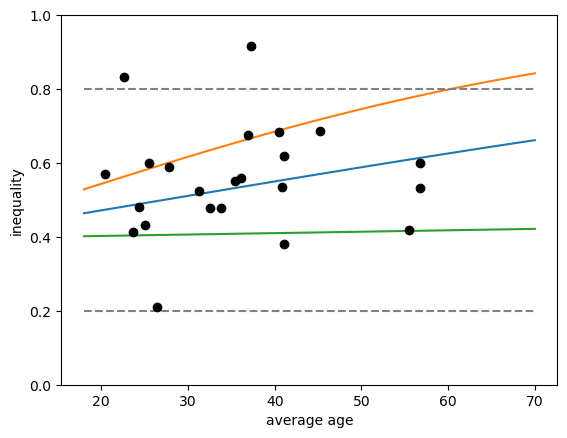

In [33]:
# coefficient scale when x is [18-100]

a = t1.posterior['intercept'].mean(('chain','draw')).values
b = t1.posterior['average age'].mean(('chain','draw')).values
b1 = np.percentile(t1.posterior['average age'],97.5)
b2 = np.percentile(t1.posterior['average age'],2.5)

x = np.linspace(18,70,100)
y = b * x + a
y = np.exp(y) / (1 + np.exp(y))
y1 = b1 * x + a
y1 = np.exp(y1) / (1 + np.exp(y1))
y2 = b2 * x + a
y2 = np.exp(y2) / (1 + np.exp(y2))

plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2)
#plt.plot(x,[0.5]*100,'--',color='grey')
plt.plot(x,[0.8]*100,'--',color='grey')
plt.plot(x,[0.2]*100,'--',color='grey')
plt.ylabel('inequality')
plt.xlabel('average age')
plt.plot(bayaka_average_age,k/n,'o',color='black',label='observed')
plt.ylim([0,1])

# Agta Bayesian Data Analysis

In [35]:
agta_data = import_agta()

agta_average_age = (agta_data.agem.values + agta_data.agefem.values) / 2
agta_age_diffs = agta_data.agem.values - agta_data.agefem.values
agta_data['camp'] = np.array(pd.Categorical(agta_data['camp']).codes,dtype=np.int64)
agta_data['social_differences'] = agta_data.male_social - agta_data.female_social
agta_data['difference_in_z_score'] = agta_data.male_z_social - agta_data.female_z_social
agta_data

id       agem     agefem  camp  leisurem_counts  leisuref_counts   
53   [A84605]  29.016356  18.938820     0                7               11  \
1    [A54433]  35.239013  26.079014     0               10                9   
51   [A84603]  24.441839  18.134339     0                9                4   
50   [A84595]  35.000000  26.634579     0                6               12   
49   [A84592]  24.851313  18.780000     0                5               13   
48   [A84586]  42.845203  41.774581     0                5                5   
52   [A84600]  62.170305  56.628730     0               17               17   
18   [A67094]  47.918799  48.671077     1                9               14   
16   [A66024]  27.571795  25.450000     1               27               26   
15   [A66016]  44.835551  35.426478     1               18               13   
14   [A66034]  20.476072  18.910000     1               10               11   
13   [A66009]  61.930971  50.716094     1               12               16   
17   [A67050]  40.794355  34.176915     1               28               20   
11   [A66046]  46.210606  45.095910     1               15                9   
10   [A66168]  64.089444  57.677601     1               16               19   
9    [A66040]  23.289649  23.919095     1               17               14   
8    [A66160]  23.971906  20.773998     1               22               12   
12   [A66001]  31.043647  30.709233     1               12                9   
38  [A771173]  33.140621  21.427618     2               10               14   
39  [A771179]  42.849115  38.658542     2               12               14   
40  [A771190]  58.890532  59.312726     2               13               13   
24   [A67170]  28.390677  23.586951     3               22               12   
23   [A67132]  42.118708  41.455268     3                6                4   
21   [A67125]  26.052643  20.434141     3                8               11   
22   [A67120]  26.871146  25.757228     3               21               15   
6    [A62546]  35.606552  36.460461     4                9                9   
7    [A62563]  50.125443  46.667627     4                4                6   
47  [A791082]  48.948534  41.447574     5                4                5   
46  [A791080]  22.783539  18.956000     5                4               19   
45  [A791078]  56.734460  50.012265     5                6                6   
20  [A671222]  25.500000  21.500000     6                6                6   
19   [A67075]  40.611318  27.506900     6                6                5   
36   [A74209]  67.324763  72.795455     7               10               20   
37   [A74196]  48.000000  44.029868     7                4               12   
35   [A74221]  51.331363  47.019089     7               12               12   
26   [A74247]  46.919969  40.922656     7                9               13   
33   [A74252]  55.926106  51.426421     7               10               12   
32   [A74277]  35.023133  27.309277     7               16               22   
31   [A74286]  77.334863  68.905590     7               11                7   
30   [A74245]  26.634353  20.000000     7                4                7   
29   [A74235]  43.211687  37.072435     7               16                8   
5    [A58618]  39.653202  36.193327     7               13                9   
25  [A741047]  30.000000  24.000000     7                4                1   
27   [A74267]  30.222873  29.024711     7                2                9   
34   [A74265]  49.139992  38.137595     7               10                6   
28   [A74294]  31.438473  37.000000     7                1                7   
44  [A781196]  48.000000  43.925125     8                4                2   
42  [A781149]  58.248539  50.079068     8               14                7   
41  [A781145]  38.500000  22.711979     8                2                5   
43  [A781155]  45.726829  23.573559     8                3   

In [36]:
agta_data.difference_in_z_score.values.mean(), agta_data.difference_in_z_score.values.std() 

np.mean(agta_data.leisurem_counts.values / agta_data.budget.values), np.std(agta_data.leisurem_counts.values / agta_data.budget.values)

(0.48710604581162187, 0.1448718231598176)

In [37]:
x = agta_data.male_z_social.values
y = agta_data.female_z_social.values

np.corrcoef(x,y)

array([[1.        , 0.03577594],
       [0.03577594, 1.        ]])

In [38]:
x = agta_data.male_z_social.values
y = agta_data.female_z_social.values

stats.pearsonr(x,y)

PearsonRResult(statistic=0.035775940606355944, pvalue=0.7973107314527726)

-124.20000228107759


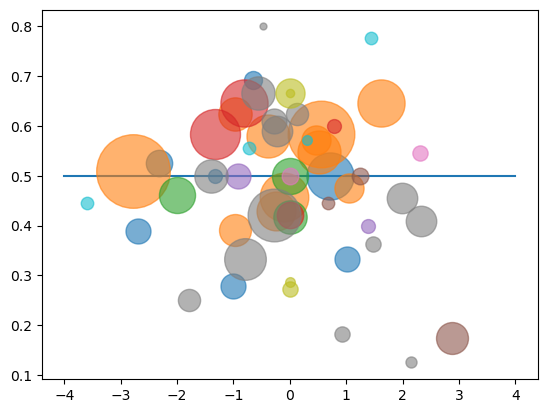

In [39]:
import matplotlib.colors as plc

a = 0
b = 0


k = agta_data.leisurem_counts.values
n = agta_data.budget.values
x = agta_data.difference_in_z_score.values
camp = agta_data.camp.values

inequality = k / n

p = np.exp(a + b*x) / (1 + np.exp(a + b*x))
loglike = stats.binom(p=p,n=n).logpmf(k)
loglike = np.sum(loglike)

print(loglike)

x_plot = np.linspace(-4,4,100)
p_plot = np.exp(a + b*x_plot) / (1 + np.exp(a + b*x_plot))

plt.plot(x_plot,p_plot)

camp_color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

for i in range(len(k)):

    plt.plot(x[i],inequality[i],'o',markersize=n[i],color=camp_color[camp[i]],alpha=0.6)

## Prior modeling

In [40]:
k = agta_data.leisurem_counts.values
n = agta_data.budget.values
x1 = agta_data.difference_in_z_score.values
x2 = agta_average_age
x3 = agta_age_diffs
camp = agta_data.camp.values

with pm.Model() as m2_agta:
    
    # hyper prior
    hb1mu = pm.Normal('group-level social capital',0,0.5)
    hb1std = pm.Exponential('group-level variation',1)
    
    # intercept
    a = pm.Normal('intercept',0,2)
    
    # slope
    bz = pm.Normal('bz',hb1mu,1,shape=10)
    b1 = pm.Deterministic('camp-level social capital',hb1std*bz)
    b2 = pm.Normal('average age',0,0.005)
    b3 = pm.Normal('age difference',0,0.03)
    
    # regression equation
    p = pm.invlogit(a + b1[camp]*x1 + b2*x2 + b3*x3)
    p = pm.Deterministic('p',p)
    
    # outcome distribution
    y = pm.Binomial('y',p=p,n=n,observed=k)

In [41]:
k = agta_data.leisurem_counts.values
n = agta_data.budget.values
x1 = agta_data.difference_in_z_score.values
x2 = agta_average_age
x3 = agta_age_diffs
camp = agta_data.camp.values

with pm.Model() as m2_agta_2:
    
    # hyper prior
    hb1mu = pm.Normal('group-level social capital',0,0.5)
    hb1std = pm.Exponential('group-level variation',1)
    
    # intercept
    a = pm.Normal('intercept',0,2)
    
    # slope
    bz = pm.Normal('bz',hb1mu,1,shape=10)
    b1 = pm.Deterministic('camp-level social capital',hb1std*bz)
    b2 = pm.Normal('average age',0,0.015)
    b3 = pm.Normal('age difference',0,0.03)
    
    # regression equation
    p = pm.invlogit(a + b1[camp]*x1 + b2*x2 + b3*x3)
    p = pm.Deterministic('p',p)
    
    # outcome distribution
    y = pm.Binomial('y',p=p,n=n,observed=k)

### Relational wealth prior predictions

(0.0, 1.0)

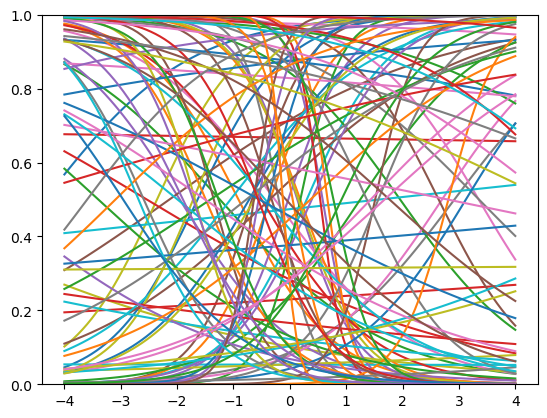

In [42]:
x = np.linspace(-4,4,100)

for i in range(100):
    
    a = stats.norm(0,2).rvs()
    mu = stats.norm(0,1).rvs()
    std = stats.expon(loc=0,scale=1).rvs()
    b = stats.norm(mu,std).rvs()
    y = np.exp(a + b * x) / (1 + np.exp(a + b * x))

    plt.plot(x,y)
plt.ylim([0,1])

### Camp effect prior prediction

Sampling: [age difference, average age, bz, group-level social capital, group-level variation, intercept, y]


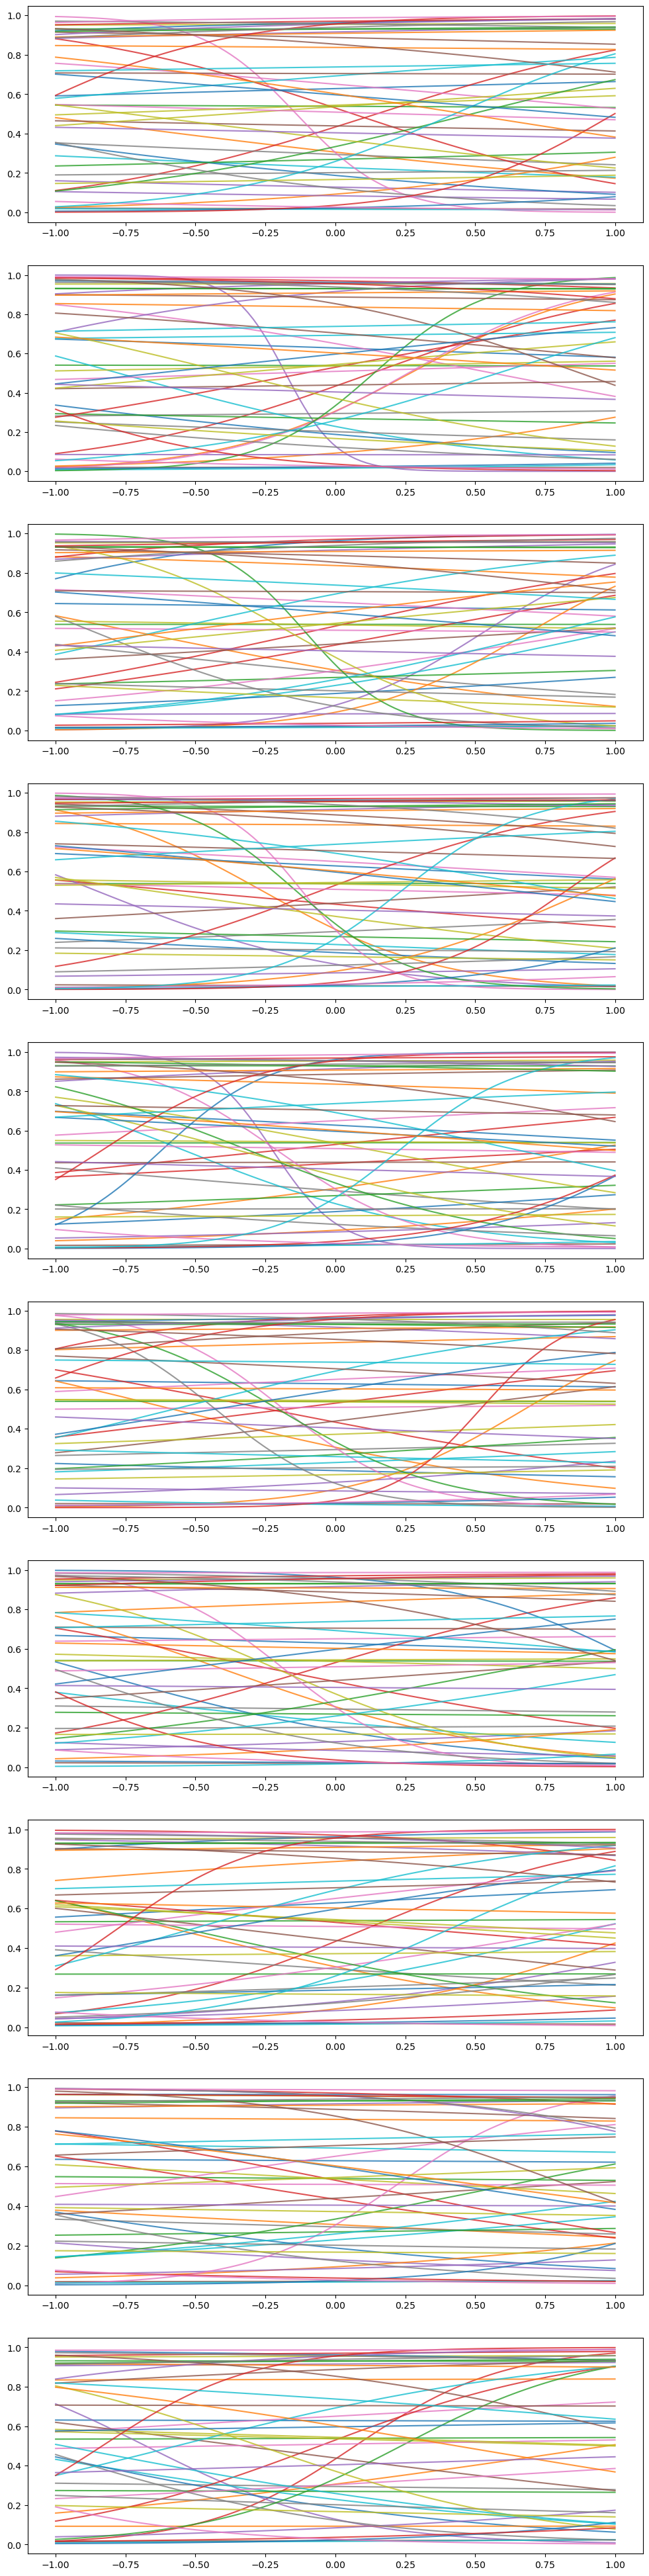

In [43]:
num_samples = 50

with m2_agta:
    pp2 = pm.sample_prior_predictive(num_samples)

x = np.linspace(-1,1,100)

f,ax = plt.subplots(10,figsize=(12,50))

for i in range(num_samples):
    
    for j in range(10):

        a = pp2.prior['intercept'][0][i].values
        b = pp2.prior['camp-level social capital'][0][i,j].values

        y = np.exp(a + b * x) / (1 + np.exp(a + b * x))

        ax[j].plot(x,y,alpha=0.8)

### Composite predictions

Sampling: [age difference, average age, bz, group-level social capital, group-level variation, intercept, y]


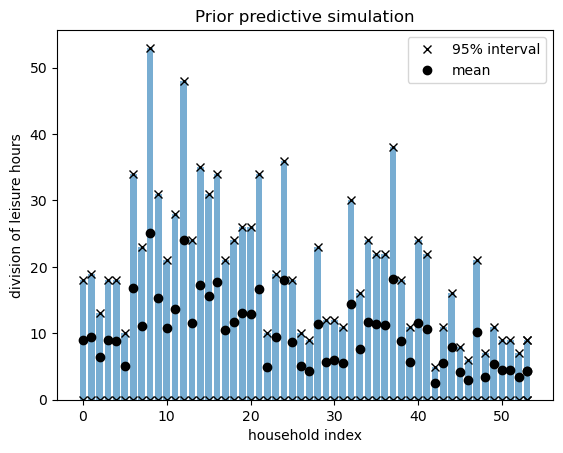

In [44]:
num_samples = 500
pop_size = len(agta_data)

with m2_agta:
    pp2 = pm.sample_prior_predictive(num_samples)
    
x = np.arange(pop_size)

plt.bar(x,n,alpha=0.6)

for i in range(pop_size):
    top = np.percentile(pp2.prior_predictive['y'][0][:,i],97.5)
    bottom = np.percentile(pp2.prior_predictive['y'][0][:,i],2.5)
    mean = pp2.prior_predictive['y'][0][:,i].mean().values
    plt.plot(i,top,'x',color="black")
    plt.plot(i,bottom,'x',color="black")
    plt.plot(i,mean,'o',color="black")
    
plt.plot(i,top,'x',color="black")
plt.plot(i,bottom,'x',color="black",label="95% interval")
plt.plot(i,mean,'o',color="black",label="mean")
    
plt.title('Prior predictive simulation')
plt.xlabel('household index')
plt.ylabel('division of leisure hours')
plt.legend()

### Age effect prior predictions

(0.0, 1.0)

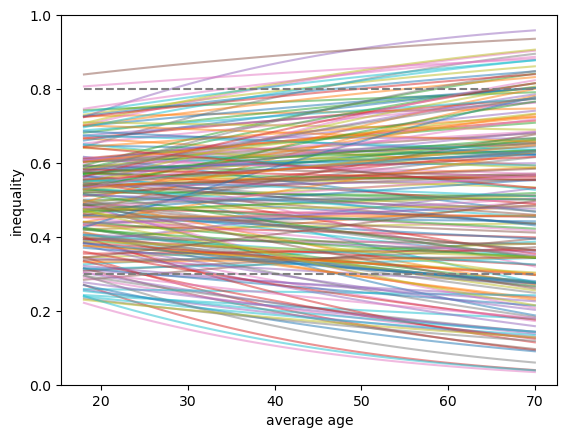

In [45]:
# coefficient scale when x is [18-100]

x = np.linspace(18,70,100)

for i in range(200):

    a = stats.norm(0,0.5).rvs()
    b = stats.norm(0.00,0.015).rvs()

    y = b * x + a
    y = np.exp(y) / (1 + np.exp(y))

    plt.plot(x,y,alpha=0.5)
    
#plt.plot(x,[0.5]*100,'--',color='grey')
plt.plot(x,[0.8]*100,'--',color='grey')
plt.plot(x,[0.3]*100,'--',color='grey')
plt.ylabel('inequality')
plt.xlabel('average age')
plt.ylim([0,1])

(0.0, 1.0)

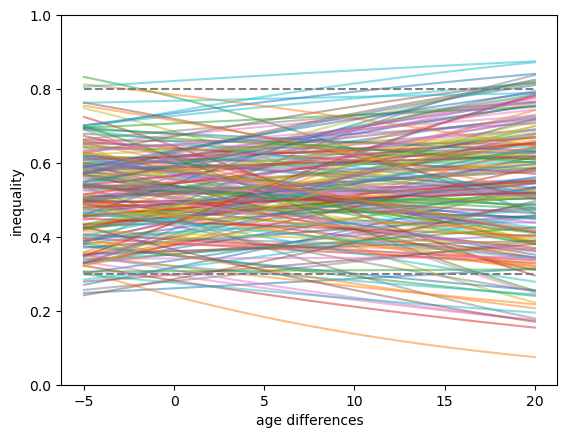

In [46]:
x = np.linspace(-5,20,100)

for i in range(200):

    a = stats.norm(0,0.5).rvs()
    b = stats.norm(0.0,0.03).rvs()

    y = b * x + a
    y = np.exp(y) / (1 + np.exp(y))

    plt.plot(x,y,alpha=0.5)
    
#plt.plot(x,[0.5]*100,'--',color='grey')
plt.plot(x,[0.8]*100,'--',color='grey')
plt.plot(x,[0.3]*100,'--',color='grey')
plt.ylabel('inequality')
plt.xlabel('age differences')
plt.ylim([0,1])

## Sampling

In [47]:
rs = RandomState(MT19937(SeedSequence(123456789)))

with m2_agta:
    t2 = pm.sample(tune=2000,draws=2000,chains=4,target_accept=0.9,random_seed=rs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group-level social capital, group-level variation, intercept, bz, average age, age difference]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.


In [48]:
rs = RandomState(MT19937(SeedSequence(123456789)))

with m2_agta_2:
    t2_2 = pm.sample(tune=2000,chains=4,target_accept=0.9,random_seed=rs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group-level social capital, group-level variation, intercept, bz, average age, age difference]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.


In [49]:
t2.to_json('trace_agta')

'trace_agta'

In [50]:
t2 = az.from_json('trace_agta')

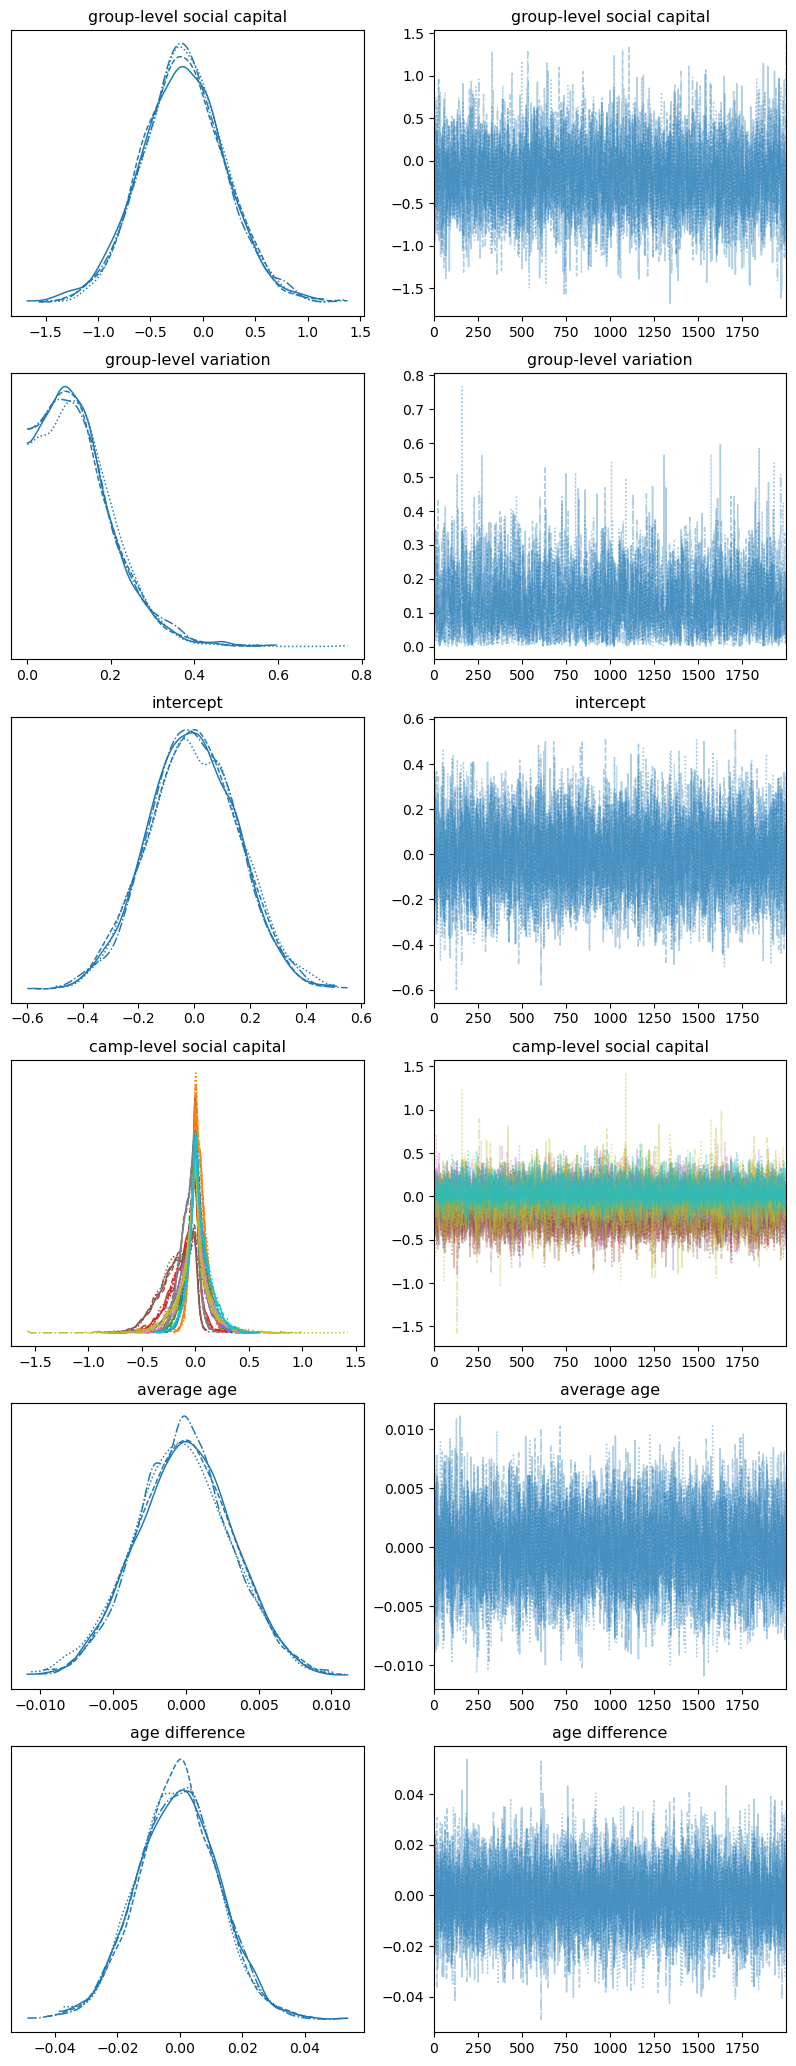

In [51]:
var_names=['group-level social capital','group-level variation',"intercept",'camp-level social capital','average age','age difference']

az.plot_trace(t2,var_names=var_names,figsize=(10,26));

In [52]:
var_names=['group-level social capital','group-level variation',"intercept",'camp-level social capital','average age','age difference']

az.summary(t2,var_names=var_names,hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean   
group-level social capital   -0.185  0.402    -0.974      0.613      0.006  \
group-level variation         0.126  0.085     0.000      0.283      0.002   
intercept                    -0.003  0.159    -0.325      0.299      0.002   
camp-level social capital[0]  0.013  0.084    -0.145      0.201      0.001   
camp-level social capital[1]  0.028  0.067    -0.094      0.170      0.001   
camp-level social capital[2]  0.007  0.111    -0.220      0.247      0.001   
camp-level social capital[3] -0.098  0.134    -0.394      0.122      0.002   
camp-level social capital[4] -0.041  0.137    -0.341      0.236      0.002   
camp-level social capital[5] -0.181  0.152    -0.479      0.042      0.003   
camp-level social capital[6] -0.001  0.124    -0.259      0.268      0.001   
camp-level social capital[7] -0.061  0.080    -0.234      0.076      0.001   
camp-level social capital[8] -0.023  0.164    -0.381      0.303      0.002   
camp-level social capital[9]  0.038  0.109    -0.172      0.274      0.001   
average age                  -0.000  0.003    -0.007      0.006      0.000   
age difference               -0.001  0.013    -0.026      0.024      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
group-level social capital      0.005    3892.0    4783.0    1.0  
group-level variation           0.001    2195.0    3387.0    1.0  
intercept                       0.002    5944.0    5784.0    1.0  
camp-level social capital[0]    0.001    9699.0    6987.0    1.0  
camp-level social capital[1]    0.001    8076.0    7513.0    1.0  
camp-level social capital[2]    0.001    8997.0    7163.0    1.0  
camp-level social capital[3]    0.001    4685.0    5962.0    1.0  
camp-level social capital[4]    0.001    8423.0    6210.0    1.0  
camp-level social capital[5]    0.002    2803.0    4712.0    1.0  
camp-level social capital[6]    0.001    9953.0    6700.0    1.0  
camp-level social capital[7]    0.001    6228.0    6685.0    1.0  
camp-level social capital[8]    0.002    8218.0    5515.0    1.0  
camp-level social capital[9]    0.001    6883.0    6356.0    1.0  
average age                     0.000    6707.0    5967.0    1.0  
age difference                  0.000    9964.0    5554.0    1.0

In [53]:
t2_2

var_names=['group-level social capital','group-level variation',"intercept",'camp-level social capital','average age','age difference']

az.summary(t2_2,var_names=var_names,hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean   
group-level social capital   -0.182  0.387    -0.939      0.584      0.009  \
group-level variation         0.131  0.086     0.001      0.288      0.002   
intercept                     0.005  0.193    -0.368      0.378      0.004   
camp-level social capital[0]  0.013  0.086    -0.148      0.207      0.001   
camp-level social capital[1]  0.030  0.067    -0.093      0.170      0.001   
camp-level social capital[2]  0.009  0.112    -0.213      0.252      0.002   
camp-level social capital[3] -0.098  0.135    -0.398      0.123      0.002   
camp-level social capital[4] -0.044  0.142    -0.370      0.216      0.002   
camp-level social capital[5] -0.191  0.153    -0.475      0.048      0.003   
camp-level social capital[6]  0.000  0.126    -0.260      0.270      0.002   
camp-level social capital[7] -0.062  0.080    -0.237      0.077      0.001   
camp-level social capital[8] -0.026  0.164    -0.401      0.315      0.003   
camp-level social capital[9]  0.039  0.112    -0.179      0.279      0.002   
average age                  -0.000  0.004    -0.008      0.009      0.000   
age difference               -0.001  0.013    -0.025      0.026      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
group-level social capital      0.006    2070.0    2089.0    1.0  
group-level variation           0.002    1332.0    1764.0    1.0  
intercept                       0.003    2171.0    2481.0    1.0  
camp-level social capital[0]    0.001    4963.0    3186.0    1.0  
camp-level social capital[1]    0.001    4185.0    3292.0    1.0  
camp-level social capital[2]    0.002    5535.0    3877.0    1.0  
camp-level social capital[3]    0.002    2947.0    3298.0    1.0  
camp-level social capital[4]    0.002    3338.0    3330.0    1.0  
camp-level social capital[5]    0.002    1686.0    2396.0    1.0  
camp-level social capital[6]    0.002    5041.0    3118.0    1.0  
camp-level social capital[7]    0.001    3466.0    3465.0    1.0  
camp-level social capital[8]    0.002    3668.0    2899.0    1.0  
camp-level social capital[9]    0.001    4628.0    3405.0    1.0  
average age                     0.000    2378.0    2658.0    1.0  
age difference                  0.000    3764.0    2976.0    1.0

## Results

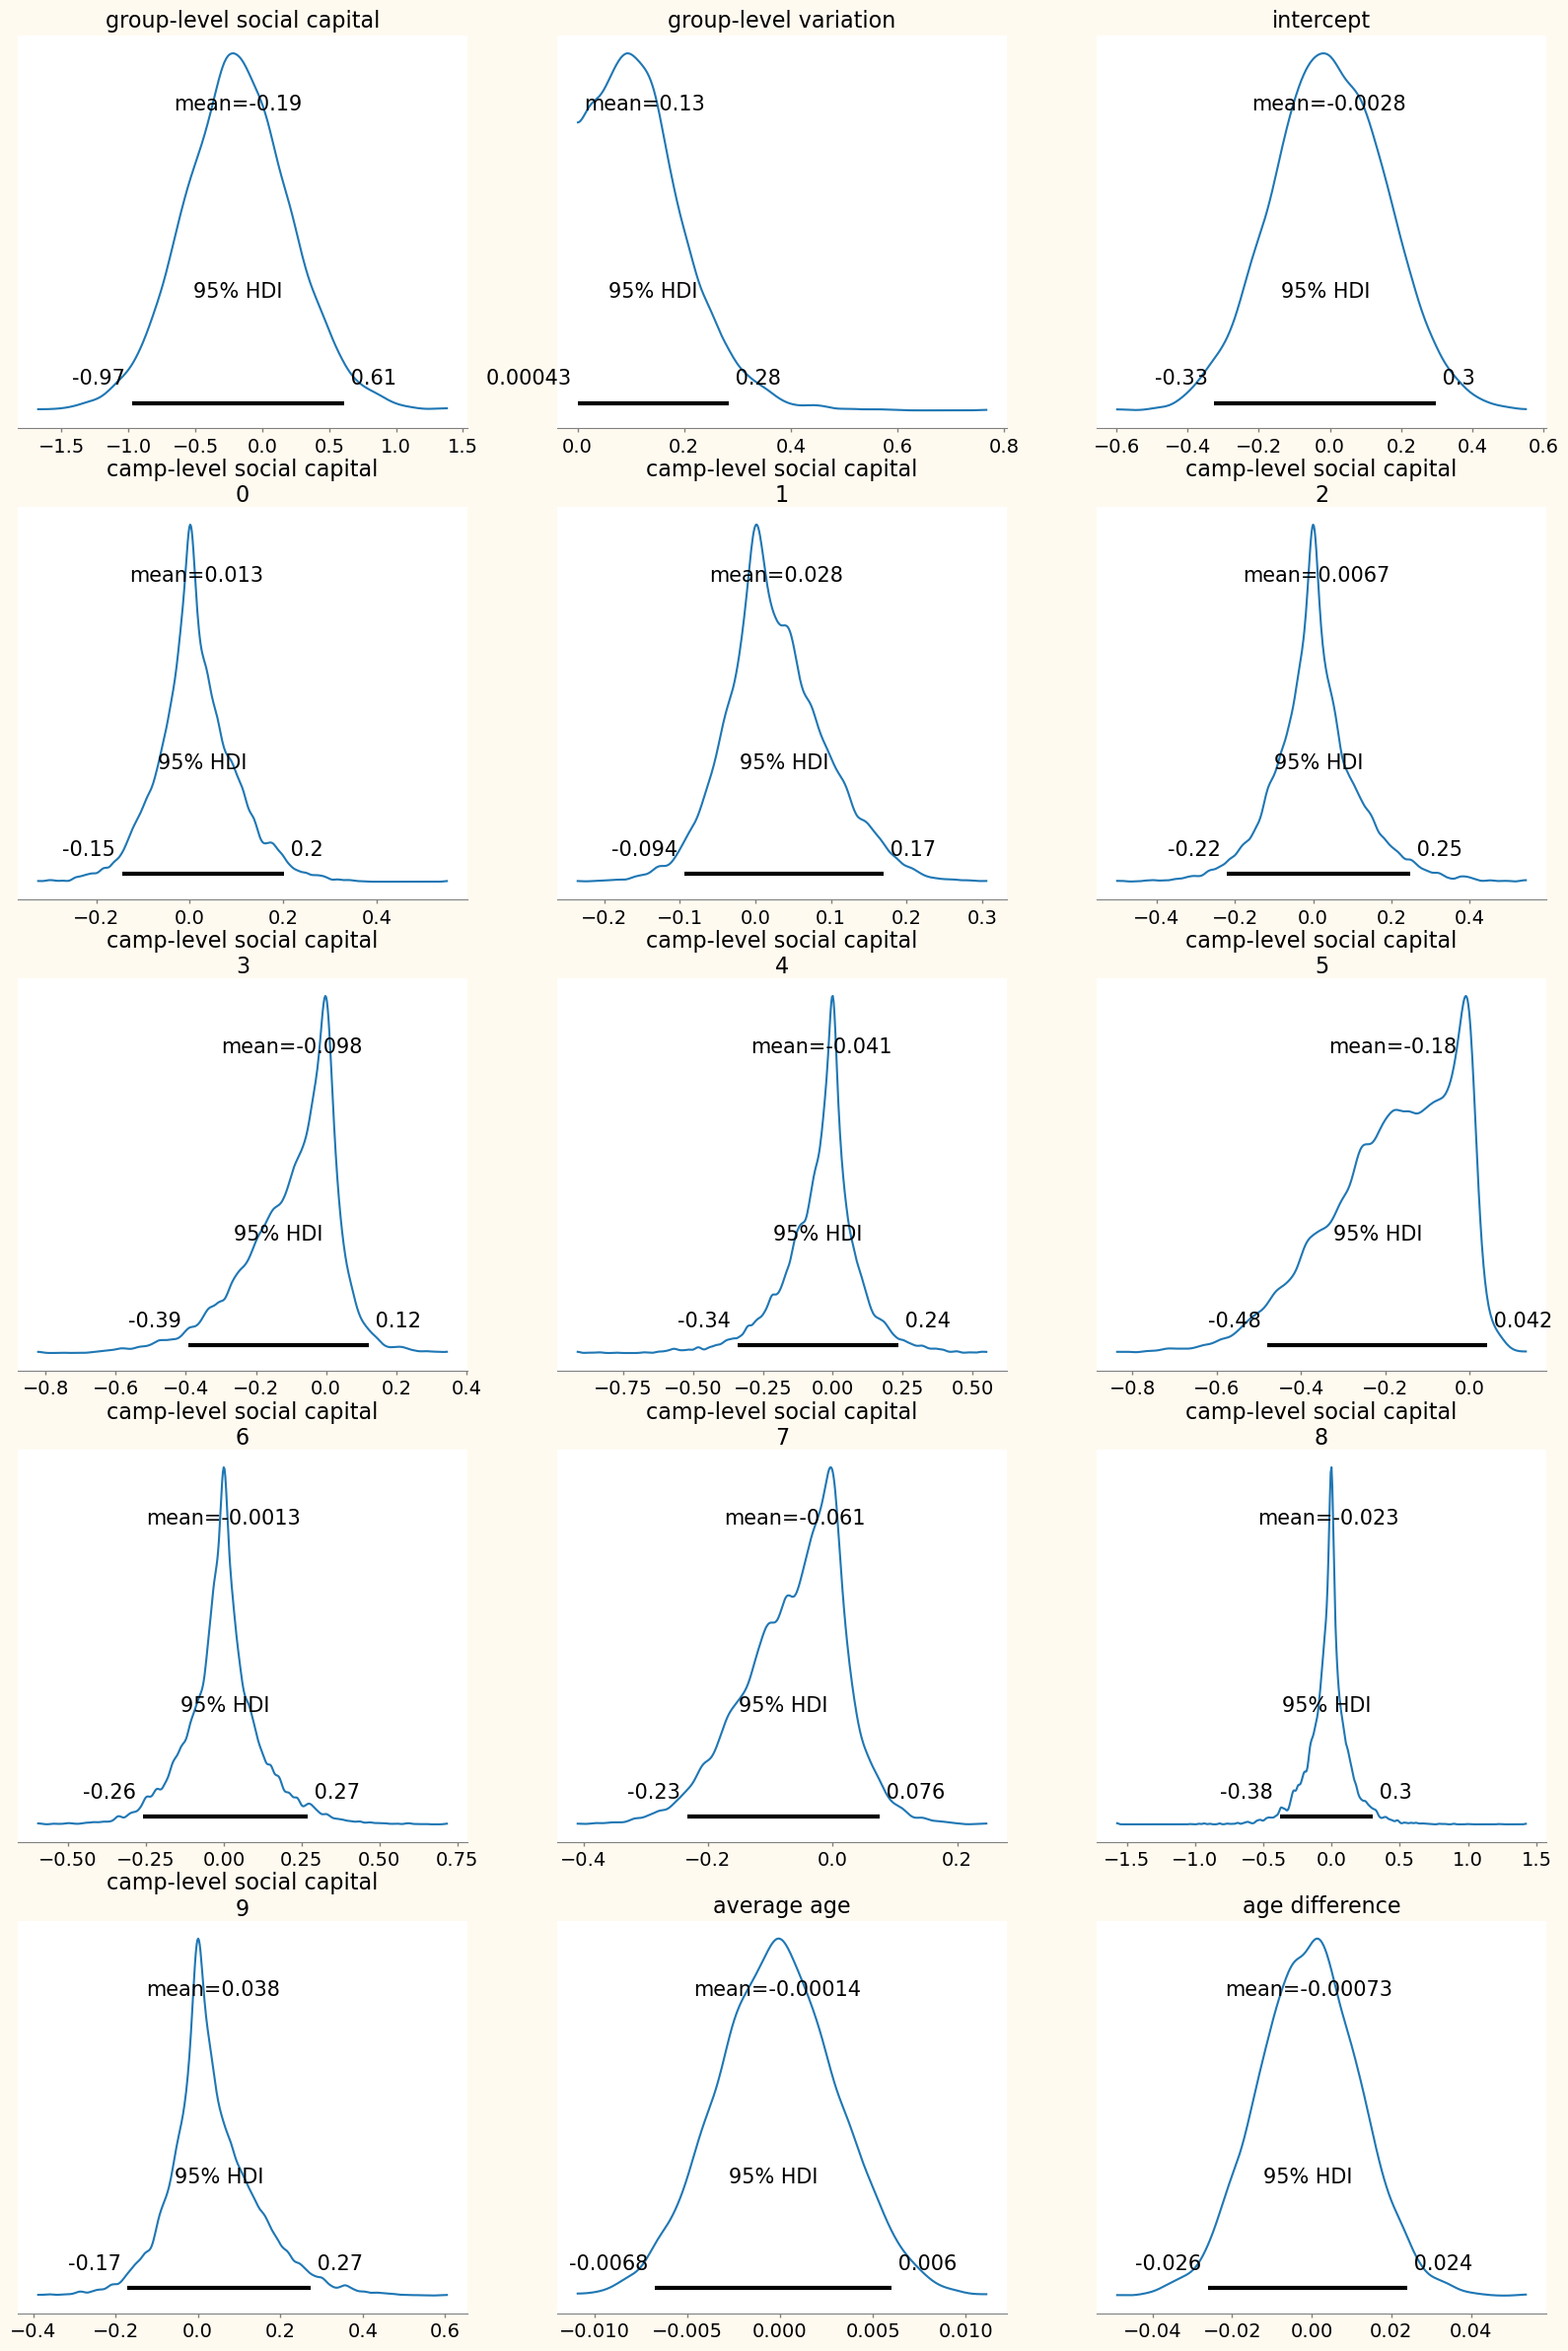

In [54]:
var_names=['group-level social capital','group-level variation',"intercept",'camp-level social capital','average age','age difference']

az.plot_posterior(t2,var_names=var_names,hdi_prob=0.95,figsize=(20,30),backend_kwargs={'facecolor':"floralwhite"});

## Posterior Checks

### Composite effect

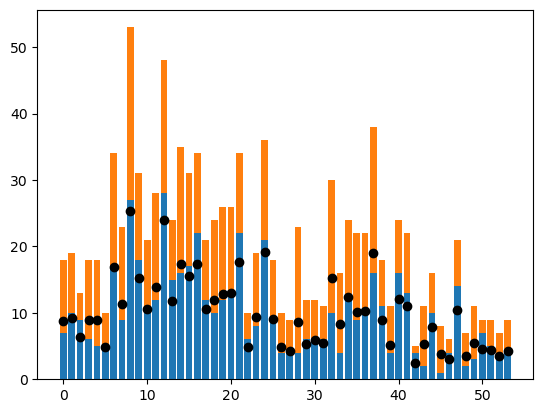

In [55]:
p = t2.posterior['p'].mean(('chain','draw'))
n = agta_data.budget.values
y = n * p
k = agta_data.leisurem_counts.values
x = np.arange(len(agta_data))
plt.bar(x,k)
plt.bar(x,n-k,bottom=k)
plt.plot(x,y,'o',color="black")

In [57]:
post_pred_agta = pm.sample_posterior_predictive(t2,model=m2_agta)
post_pred_agta

Sampling: [y]


Inference data with groups:
	> posterior_predictive
	> observed_data

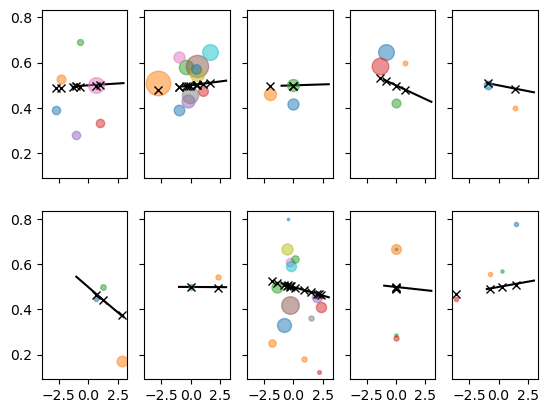

In [58]:

f, ax = plt.subplots(2,5,sharex=True,sharey=True)

pred_samples = post_pred_agta.posterior_predictive['y'].values.reshape((8000,54))
pred_k = pred_samples.mean(axis=0)

a = t2.posterior['intercept'].mean(('chain','draw')).values
b = t2.posterior['camp-level social capital'].mean(('chain','draw')).values

x = np.linspace(-1,3)

for i in range(5):
    
    y = np.exp(a + b[i]*x) / (1 + np.exp(a + b[i]*x))
    
    ax[0][i].plot(x,y,color="black")
    
    for j in range(sum(camp==i)):
        ax[0][i].plot(x1[camp == i][j],k[camp == i][j]/n[camp == i][j],'o',markersize=n[camp==i][j]/3,alpha=0.5)
        
    ax[0][i].plot(x1[camp == i],pred_k[camp == i]/n[camp == i],'x',color="black")
    
for i in range(5,10):
    
    y = np.exp(a + b[i]*x) / (1 + np.exp(a + b[i]*x))
    
    ax[1][i-5].plot(x,y,color="black")
    
    for j in range(sum(camp==i)):
        ax[1][i-5].plot(x1[camp == i][j],k[camp == i][j]/n[camp == i][j],'o',markersize=n[camp==i][j]/3,alpha=0.5)
        
    ax[1][i-5].plot(x1[camp == i],pred_k[camp == i]/n[camp == i],'x',color="black")

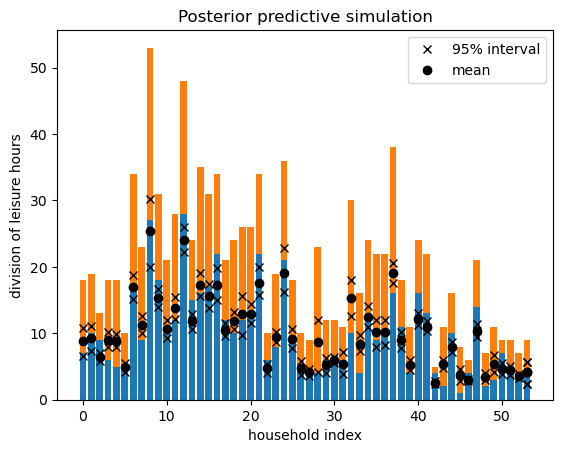

In [59]:
x = np.arange(len(agta_data))
n = agta_data.budget.values
k = agta_data.leisurem_counts.values

plt.bar(x,k)
plt.bar(x,n-k,bottom=k)

for i in range(len(agta_data)):
    top = n[i]* np.percentile(t2.posterior['p'][:,:,i],97.5)
    bottom = n[i]*np.percentile(t2.posterior['p'][:,:,i],2.5)
    mean = n[i]*t2.posterior['p'][:,:,i].mean().values
    plt.plot(i,top,'x',color="black")
    plt.plot(i,bottom,'x',color="black")
    plt.plot(i,mean,'o',color="black")
    
plt.plot(i,top,'x',color="black")
plt.plot(i,bottom,'x',color="black",label="95% interval")
plt.plot(i,mean,'o',color="black",label="mean")
    
plt.title('Posterior predictive simulation')
plt.xlabel('household index')
plt.ylabel('division of leisure hours')
plt.legend()

(0.0, 1.0)

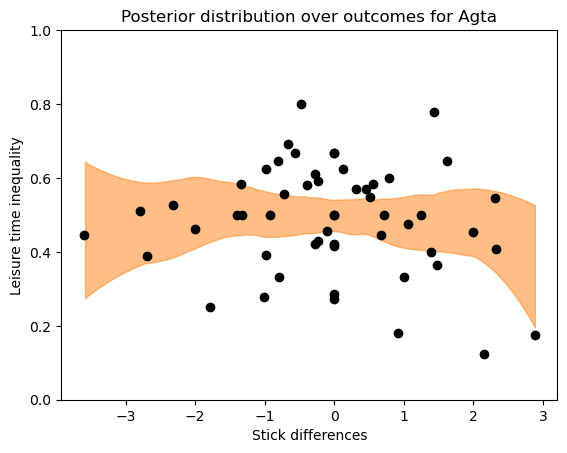

In [61]:
x = agta_data.difference_in_z_score.values
n = agta_data.budget.values
k = agta_data.leisurem_counts.values

az.plot_hdi(x,t2.posterior['p'],hdi_prob=0.95)
plt.plot(x,k/n,'o',color='black',label='observed')
plt.title('Posterior distribution over outcomes for Agta')
plt.xlabel('Stick differences')
plt.ylabel('Leisure time inequality')
plt.ylim([0,1])

### Relational wealth group-level effect

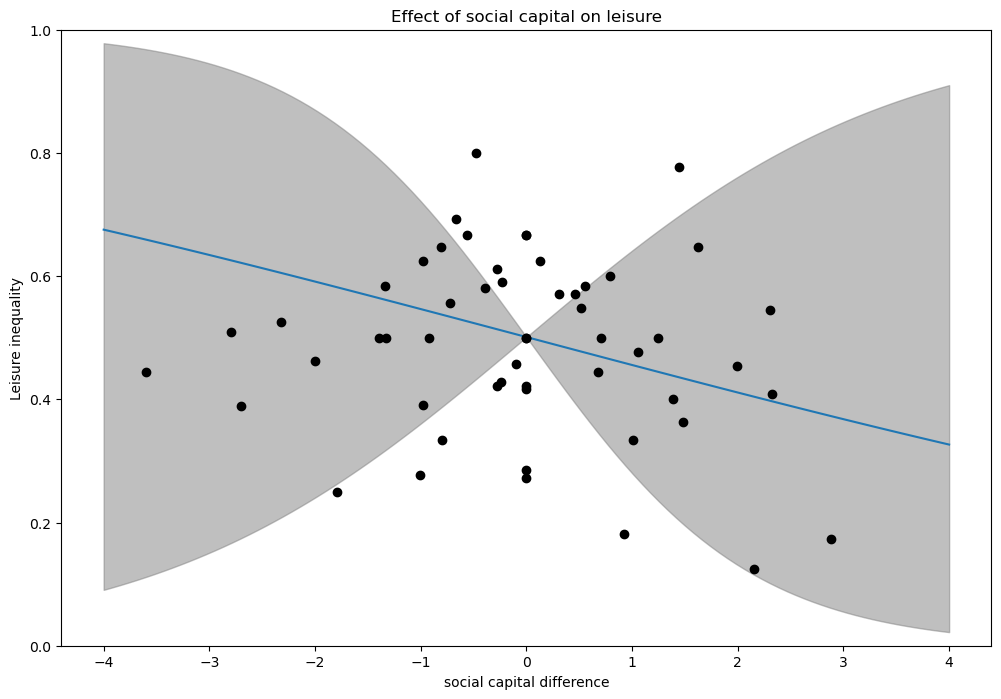

In [62]:
t2 = t2_2

x = np.linspace(-4,4,100)

k = agta_data.leisurem_counts.values
n = agta_data.budget.values

a = t2.posterior['intercept'].mean(('chain','draw')).values
b = t2.posterior['group-level social capital'].mean(('chain','draw')).values
b1 = np.percentile(t2.posterior['group-level social capital'],97.5)
b2 = np.percentile(t2.posterior['group-level social capital'],2.5)

y = np.exp(a + b*x) / (1 + np.exp(a + b*x))
y1 = np.exp(a + b1*x) / (1 + np.exp(a + b1*x))
y2 = np.exp(a + b2*x) / (1 + np.exp(a + b2*x))

plt.figure(figsize=(12,8))

plt.plot(x,y)
plt.fill_between(x,y1,y2,color="grey",alpha=0.5)
plt.plot(agta_data.difference_in_z_score.values,k/n,'o',color='black',label='observed')
plt.ylim([0,1])
plt.xlabel("social capital difference")
plt.ylabel("Leisure inequality")
plt.title("Effect of social capital on leisure");

C:\Users\dsaun\AppData\Local\Temp\ipykernel_9268\2489401255.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(ys)


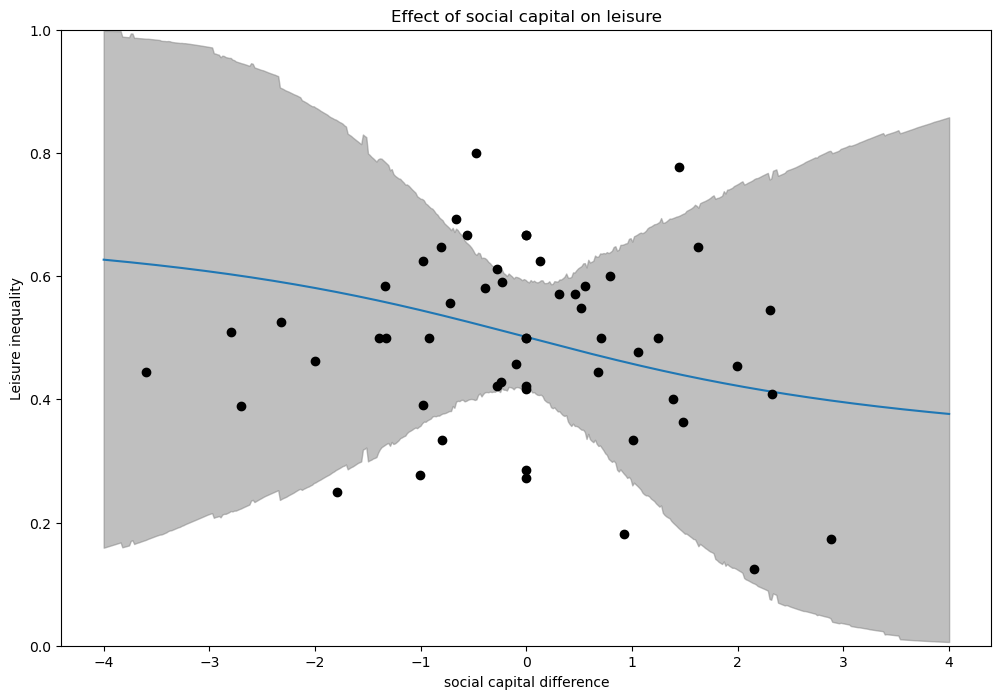

In [63]:
x = np.linspace(-4,4,500)

k = agta_data.leisurem_counts.values
n = agta_data.budget.values

intercepts = t2.posterior['intercept'].values.flatten()
slopes = t2.posterior['group-level social capital'].values.flatten()

ys = []

for i in range(4000):

    a = intercepts[i]
    b = slopes[i]
    y = np.exp(a + b*x) / (1 + np.exp(a + b*x))
    ys.append(y)
    
ys = np.array(ys)
hdis = az.hdi(ys)
y = ys.mean(axis=0) 
y1 = hdis[:,0]
y2 = hdis[:,1]

plt.figure(figsize=(12,8))

plt.plot(x,y)
plt.fill_between(x,y1,y2,color="grey",alpha=0.5)
plt.plot(agta_data.difference_in_z_score.values,k/n,'o',color='black',label='observed')
plt.ylim([0,1])
plt.xlabel("social capital difference")
plt.ylabel("Leisure inequality")
plt.title("Effect of social capital on leisure");

### Age effects

(0.0, 1.0)

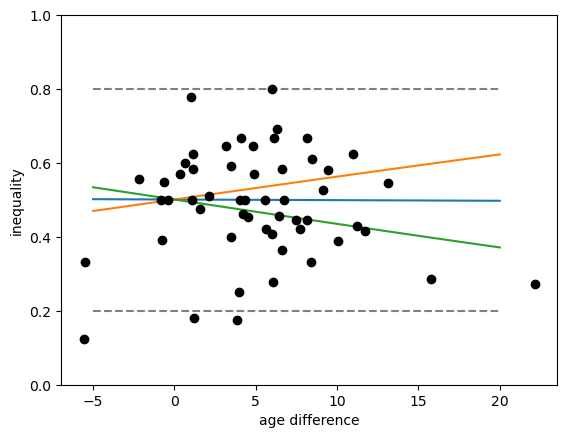

In [64]:
# coefficient scale when x = [-5,20]

x = np.linspace(-5,20,100)
a = t2.posterior['intercept'].mean(('chain','draw')).values
b = t2.posterior['age difference'].mean(('chain','draw')).values
b1 = np.percentile(t2.posterior['age difference'],97.5)
b2 = np.percentile(t2.posterior['age difference'],2.5)

y = b * x + a
y = np.exp(y) / (1 + np.exp(y))
y1 = b1 * x + a
y1 = np.exp(y1) / (1 + np.exp(y1))
y2 = b2 * x + a
y2 = np.exp(y2) / (1 + np.exp(y2))

plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2)
plt.ylabel('inequality')
plt.xlabel('age difference')
plt.plot(x,[0.8]*100,'--',color='grey')
plt.plot(x,[0.2]*100,'--',color='grey')
plt.plot(agta_age_diffs,k/n,'o',color='black',label='observed')
plt.ylim([0,1])

(0.0, 1.0)

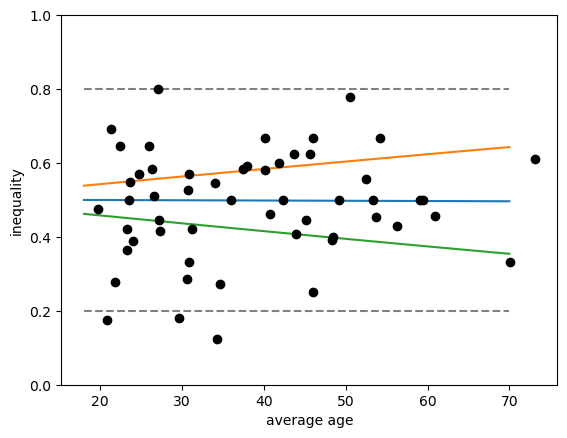

In [65]:
# coefficient scale when x is [18-100]

a = t2.posterior['intercept'].mean(('chain','draw')).values
b = t2.posterior['average age'].mean(('chain','draw')).values
b1 = np.percentile(t2.posterior['average age'],97.5)
b2 = np.percentile(t2.posterior['average age'],2.5)

x = np.linspace(18,70,100)
y = b * x + a
y = np.exp(y) / (1 + np.exp(y))
y1 = b1 * x + a
y1 = np.exp(y1) / (1 + np.exp(y1))
y2 = b2 * x + a
y2 = np.exp(y2) / (1 + np.exp(y2))

plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2)
#plt.plot(x,[0.5]*100,'--',color='grey')
plt.plot(x,[0.8]*100,'--',color='grey')
plt.plot(x,[0.2]*100,'--',color='grey')
plt.ylabel('inequality')
plt.xlabel('average age')
plt.plot(agta_average_age,k/n,'o',color='black',label='observed')
plt.ylim([0,1])